# **Ingeniería de Características**
# **Radiografías de Tórax**
## ITESM - MNA V

## Proyecto Integrador - TC5035.10

## Profesora: Dra. Grettel Barceló Alonso


### Equipo 19

Héctor Segura Quintanilla (A01154108)

Julio César García Escoto (A01795050)

Francisco Medellín Zertuche (A01794044)


## Instalación de librerías

In [53]:
!pip install -q scikit-image
!pip install -q ImageHash

In [54]:
import os
import random
import math
import shutil
import multiprocessing
from datetime import datetime
from glob import glob
from collections import Counter
from concurrent.futures import ProcessPoolExecutor, as_completed
from pathlib import Path

# Data Handling & Visualization
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from tqdm.auto import tqdm # Mantener tqdm.auto para notebooks
from IPython.display import Image, display

# Image Processing (PIL, OpenCV)
from PIL import Image
from PIL.Image import Resampling
import cv2
import imagehash

# Machine Learning & Deep Learning
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import LabelEncoder
import torch
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torchvision import models
from keras.utils import to_categorical # Añadido ya que se usa para Y_encoded

In [55]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Creación de variables para ubicación de archivos

In [56]:
data_dir = "/content/drive/MyDrive/CARDIOS - PROYECTO INTEGRADOR/Datos_og"
class_names = sorted(os.listdir(data_dir))
print("Clases encontradas:", class_names)

image_paths = []
labels = []

for class_name in class_names:
    class_dir = os.path.join(data_dir, class_name)
    for img_file in os.listdir(class_dir):
        image_paths.append(os.path.join(class_dir, img_file))
        labels.append(class_name)

df = pd.DataFrame({
    'image_path': image_paths,
    'label': labels
})

Clases encontradas: ['ASD', 'Normal', 'PDA', 'VSD']


## Héctor

# 1. Preprocesamiento de imágenes (Data Preparation)
Normalización de intensidades (ej. rescale [0,1], z-score).
* Técnicas de reducción de ruido.
* Recorte a regiones de interés (ROI).
* Generación de versiones estandarizadas (ej. redimensionado a 224×224).



##Centrado anatómico y reducción de ruido

Se procesan las imágenes para contar con versiones de las mismas que muestren únicamente el área de interés para el diagnóstico de cardiopatías. La región de interés fue identificada gracias a la asesoría de los médicos especialistas consejeros del proyecto.

Asimismo, se incluyen procedimientos para crear una máscara de la caja torácica, y en ese mismo proceso remover en la medida de lo posible los marcadores que realiza el equipo de rayos X; en este caso es la letra L o su traducción al chino. Esta marca indica al observador a qué lado del cuerpo corresponde la parte de la imagen donde está colocada.


In [ ]:
def remove_marker_inpaint(img_gray):
    """Quita marcadores mediante máscara e inpaint."""
    g = cv2.medianBlur(img_gray, 5)
    circles = cv2.HoughCircles(
        g, cv2.HOUGH_GRADIENT, dp=1.2, minDist=60,
        param1=120, param2=35, minRadius=10, maxRadius=60
    )
    mask = np.zeros_like(img_gray, dtype=np.uint8)
    if circles is not None:
        circles = np.uint16(np.around(circles[0]))
        h, w = img_gray.shape
        for x, y, r in circles:
            if y < int(h * 0.45):
                cv2.circle(mask, (x, y), int(r * 1.25), 255, -1)
    if mask.any():
        inpainted = cv2.inpaint(img_gray, mask, 3, cv2.INPAINT_TELEA)
        return inpainted, mask
    else:
        return img_gray.copy(), mask


def thorax_mask(img_gray):
    """Segmenta tórax (máscara binaria robusta)."""
    # Mejora de contraste + inversión para resaltar regiones claras
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    ce = clahe.apply(img_gray)
    inv = cv2.bitwise_not(ce)

    # Umbral adaptado (Otsu) + limpieza morfológica
    _, th = cv2.threshold(inv, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    th = cv2.morphologyEx(th, cv2.MORPH_OPEN, np.ones((5,5), np.uint8), iterations=1)
    th = cv2.morphologyEx(th, cv2.MORPH_CLOSE, np.ones((15,15), np.uint8), iterations=1)

    # Componentes conectados y filtro por área/posición (descarta ruido periférico)
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(th, connectivity=8)
    h, w = img_gray.shape
    cx_allowed = (int(w*0.15), int(w*0.85))
    candidate_idx = []
    for i in range(1, num_labels):
        area = stats[i, cv2.CC_STAT_AREA]
        x, y, bw, bh, _ = stats[i]
        cx, cy = centroids[i]
        if area > 0.002 * (h*w) and cx_allowed[0] <= cx <= cx_allowed[1]:
            candidate_idx.append((area, i))

    mask = np.zeros_like(th)
    for _, i in sorted(candidate_idx, reverse=True)[:3]:
        mask[labels == i] = 255

    # Si nada pasó el filtro, toma el componente más grande
    if not mask.any():
        if num_labels > 1:
            i = 1 + np.argmax(stats[1:, cv2.CC_STAT_AREA])
            mask[labels == i] = 255

    # Convex hull por contorno para rellenar huecos y suavizar silueta
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    hull_mask = np.zeros_like(mask)
    for cnt in contours:
        hull = cv2.convexHull(cnt)
        cv2.drawContours(hull_mask, [hull], -1, 255, -1)

    # Ligera dilatación para cubrir bordes
    hull_mask = cv2.dilate(hull_mask, np.ones((7,7), np.uint8), iterations=1)
    return hull_mask


def bbox_from_mask(mask, tighten=0.02):
    """BBox apretado a partir de máscara."""
    ys, xs = np.where(mask > 0)
    if len(xs) == 0:
        return (0, 0, mask.shape[1], mask.shape[0])
    x0, x1 = xs.min(), xs.max()
    y0, y1 = ys.min(), ys.max()
    w = x1 - x0 + 1
    h = y1 - y0 + 1
    x0 += int(w * tighten); x1 -= int(w * tighten)
    y0 += int(h * tighten); y1 -= int(h * tighten)
    x0 = max(x0, 0); y0 = max(y0, 0)
    x1 = min(x1, mask.shape[1]-1); y1 = min(y1, mask.shape[0]-1)
    return (x0, y0, x1, y1)


def trim_head_abdomen(y0, y1, h, head_frac=0.1, abdomen_frac=0.20):
    """Recorta cabeza/abdomen por fracciones verticales."""
    y0_new = max(y0, int(h * head_frac))
    y1_new = min(y1, int(h * (1.0 - abdomen_frac)))
    if y1_new <= y0_new:
        return y0, y1
    return y0_new, y1_new


def crop_to_bbox(img, bbox):
    """Recorta imagen al bbox (incluye bordes)."""
    x0, y0, x1, y1 = bbox
    return img[y0:y1+1, x0:x1+1]


def fit_to_square(img, size=320, pad_mode="constant"):
    """Redimensiona con aspecto y centra en lienzo cuadrado."""
    # Cálculo de escala manteniendo aspecto
    h, w = img.shape[:2]
    if h == 0 or w == 0:
        raise ValueError("Imagen vacía.")
    scale = min(size / w, size / h)
    nw, nh = int(round(w * scale)), int(round(h * scale))

    # Interpolación estable según reducción/ampliación
    interp = cv2.INTER_AREA if scale < 1.0 else cv2.INTER_CUBIC
    resized = cv2.resize(img, (nw, nh), interpolation=interp)

    # Lienzo y modo de padding
    if pad_mode == "median":
        border_vals = np.concatenate([resized[0, :], resized[-1, :], resized[:, 0], resized[:, -1]])
        fill = int(np.median(border_vals))
        canvas = np.full((size, size), fill, dtype=img.dtype)
    elif pad_mode == "replicate":
        canvas = np.zeros((size, size), dtype=img.dtype)
    else:  # "constant" => negro
        canvas = np.zeros((size, size), dtype=img.dtype)

    # Colocar centrado
    top  = (size - nh) // 2
    left = (size - nw) // 2
    canvas[top:top+nh, left:left+nw] = resized

    # Si se eligió "replicate", extiende bordes (bandas)
    if pad_mode == "replicate":
        if top > 0:
            canvas[:top, left:left+nw] = resized[0:1, :]
        if size - (top+nh) > 0:
            canvas[top+nh:, left:left+nw] = resized[-1:, :]
        if left > 0:
            canvas[:, :left] = canvas[:, left:left+1]
        if size - (left+nw) > 0:
            canvas[:, left+nw:] = canvas[:, left+nw-1:left+nw]

    meta = {"scale": scale, "pad_top": top, "pad_left": left, "out_size": size}
    return canvas, meta


def process_one(img_gray):
    """Pipeline: limpia, segmenta, recorta y normaliza a 320×320."""
    # 1) Quitar marcadores
    no_marker, marker_mask = remove_marker_inpaint(img_gray)

    # 2) Segmentar tórax y obtener bbox
    mask = thorax_mask(no_marker)
    x0, y0, x1, y1 = bbox_from_mask(mask)

    # 3) Ajuste lateral leve del bbox (reduce bordes)
    w = x1 - x0 + 1
    shrink_frac = 0.10
    shrink = int(w * shrink_frac)
    x0 = x0 + shrink
    x1 = x1 - shrink
    x1 = max(x1, x0 + 1)

    # 4) Recorte vertical (cabeza/abdomen)
    h, w = img_gray.shape
    y0, y1 = trim_head_abdomen(y0, y1, h)
    bbox = (x0, y0, x1, y1)

    # 5) Recorte y normalización de tamaño (letterbox)
    cropped = crop_to_bbox(no_marker, bbox)
    resized320, meta = fit_to_square(cropped, size=320, pad_mode="median")

    return {
        "no_marker": no_marker,
        "marker_mask": marker_mask,
        "mask": mask,
        "bbox": bbox,
        "cropped": cropped,
        "resized320": resized320,
        "resize_meta": meta
    }


def process_folder(input_dir, output_dir, postfix="_cropped"):
    """Procesa directorio y guarda imágenes 320×320."""
    # Itera imágenes soportadas, ejecuta pipeline y guarda salida normalizada
    input_dir = Path(input_dir)
    output_dir = Path(output_dir)
    output_dir.mkdir(parents=True, exist_ok=True)
    exts = {".jpg", ".jpeg", ".png", ".bmp", ".tif", ".tiff"}
    for p in sorted(input_dir.iterdir()):
        if p.suffix.lower() in exts:
            img = cv2.imread(str(p), cv2.IMREAD_GRAYSCALE)
            if img is None:
                continue
            out = process_one(img)
            out_name = f"{p.stem}{postfix}{p.suffix.lower()}"
            out_path = output_dir / out_name
            cv2.imwrite(str(out_path), out["resized320"])


def original_from_cropped(cropped_path: Path, base_dir: Path, postfix="_cropped"):
    """Reconstruye ruta del original a partir del nombre recortado."""
    stem = cropped_path.stem
    if stem.endswith(postfix):
        stem = stem[:-len(postfix)]
    return base_dir / f"{stem}{cropped_path.suffix}"


In [ ]:
carpeta = Path("drive/MyDrive/CARDIOS - PROYECTO INTEGRADOR/Datos_og")
input_dir_normal  = carpeta / "Normal"
output_dir_normal = carpeta / "Normal_crops"

input_dir_ASD  = carpeta / "ASD"
output_dir_ASD = carpeta / "ASD_crops"

input_dir_PDA  = carpeta / "PDA"
output_dir_PDA = carpeta / "PDA_crops"

input_dir_VSD  = carpeta / "VSD"
output_dir_VSD = carpeta / "VSD_crops"

In [ ]:
process_folder(input_dir_normal, output_dir_normal)
process_folder(input_dir_ASD, output_dir_ASD)
process_folder(input_dir_PDA, output_dir_PDA)
process_folder(input_dir_VSD, output_dir_VSD)


## Muestras

Se presenta un subconjunto de imágenes procesadas por nuestro *pipeline* de recorte a la región de interés. Este mismo procesamiento se aplicó (celda inmediata superior) a todas las imágenes del conjunto de datos, divido en las ya conocidas 4 clases: ASD, PDA, VSD y Normal.

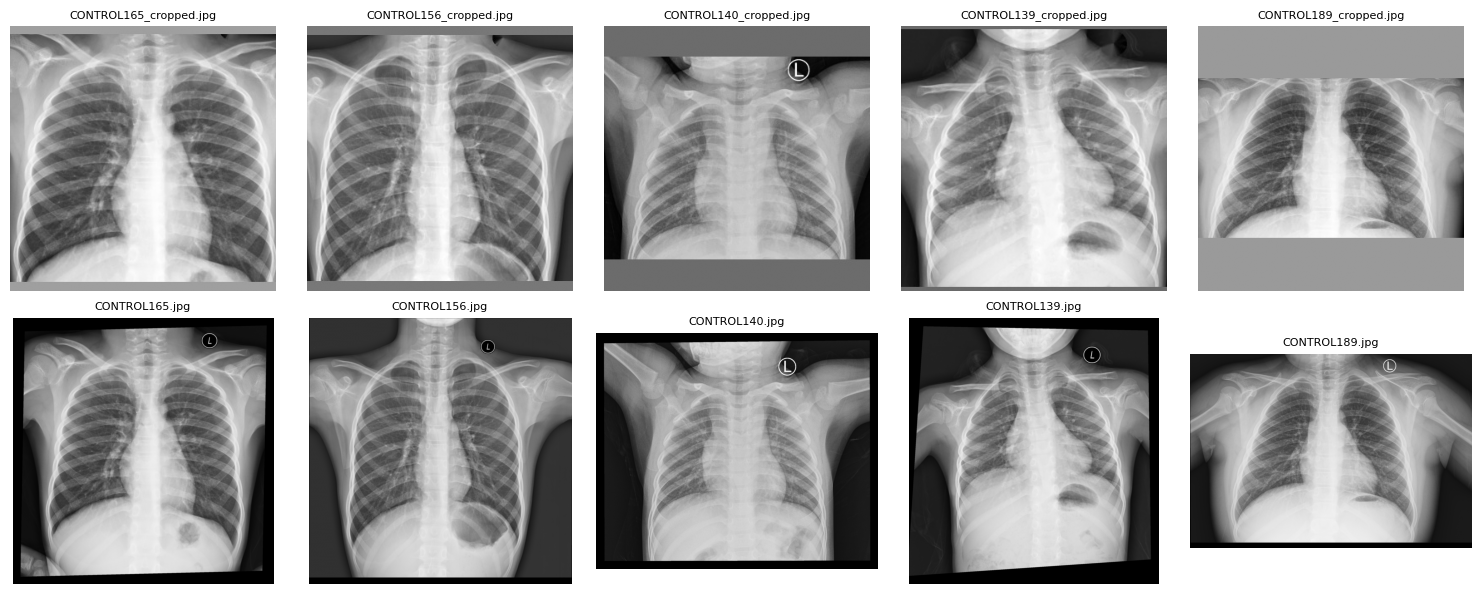

In [ ]:
fig, axes = plt.subplots(2, 5, figsize=(3*5, 6))
exts = {".jpg", ".jpeg", ".png", ".bmp", ".tif", ".tiff"} # Define exts here
rutas = [p for p in output_dir_normal.iterdir() if p.suffix.lower() in exts]
muestra = random.sample(rutas, min(5, len(rutas)))

for j, p_cropped in enumerate(muestra):
    # Fila 0: recortadas
    img_c = cv2.imread(str(p_cropped), cv2.IMREAD_GRAYSCALE)
    axes[0, j].imshow(img_c, cmap="gray")
    axes[0, j].set_title(p_cropped.name, fontsize=8)
    axes[0, j].axis("off")

    # Fila 1: originales
    p_orig = original_from_cropped(p_cropped, input_dir_normal, postfix="_cropped")
    img_o = cv2.imread(str(p_orig), cv2.IMREAD_GRAYSCALE)

    axes[1, j].imshow(img_o, cmap="gray")
    axes[1, j].set_title(p_orig.name, fontsize=8)
    axes[1, j].axis("off")

plt.tight_layout()
plt.show()

# 3. *Feature Engineering* y *Feature Construction*
* Combinación de características (ejemplo: cocientes de intensidades, índices de contraste).
* Features derivados de máscaras de segmentación (ejemplo: proporción área de pulmón/área total).
* Indicadores binarios (ejemplo: presencia/ausencia de ciertas estructuras).

In [68]:
data_dir_og = "/content/drive/MyDrive/CARDIOS - PROYECTO INTEGRADOR/Datos_og"
class_names_og = sorted(os.listdir(data_dir_og))

data_dir_crop = "/content/drive/MyDrive/CARDIOS - PROYECTO INTEGRADOR/Datos_crop"
class_names_crop = sorted(os.listdir(data_dir_crop))

print("Clases encontradas OG:", class_names_og)
print("Clases encontradas CROP:", class_names_crop)

image_paths_og = []
labels_og = []

image_paths_crop = []
labels_crop = []

for class_name_og in class_names_og:
    class_dir_og = os.path.join(data_dir_og, class_name_og)
    for img_file_og in os.listdir(class_dir_og):
        image_paths_og.append(os.path.join(class_dir_og, img_file_og))
        labels_og.append(class_name_og)

for class_name_crop in class_names_crop:
    class_dir_crop= os.path.join(data_dir_crop, class_name_crop)
    for img_file_crop in os.listdir(class_dir_crop):
        image_paths_crop.append(os.path.join(class_dir_crop, img_file_crop))
        labels_crop.append(class_name_crop)

df_og = pd.DataFrame({
    'image_path': image_paths_og,
    'label': labels_og
})

df_crop = pd.DataFrame({
    'image_path': image_paths_crop,
    'label': labels_crop
})

Clases encontradas OG: ['ASD', 'Normal', 'PDA', 'VSD']
Clases encontradas CROP: ['ASD_crops', 'Normal_crops', 'PDA_crops', 'VSD_crops']


### **Cálculo de Features de intensidad - pixeles**
<BR>

Nuestro objetivo para la ceracion de los siguientes features es convertir cada imagen en un vector de estadísticas descriptivas que resumen la forma de la distribución de intensidades.

Los features y los gráficos generados muestran que hay diferencias notables entre las clases en cuanto a brillo, contraste y forma de la distribución de píxeles, lo que podria justificar un posible uso de estos features en tu modelo de clasificación.

Estos son features estadísticas útiles para clasificar imágenes, basados en pixeles.

- Primero nos aseguremos que los calculos sean en punto flotante, convirtiendo las imagenes a flotantes.

- Calculamos la intensidad promedio (pix_mean) mide brillo global de la imagen.

- Medimos el  contraste (pix_std: variación, qué tan dispersos están los valores de píxel).

- Calculamos si la distribución de intensidades está cargada hacia valores bajos (pix_skew: sesgo), (oscura) o altos (clara).

- Calculamos la curtosis para ver si la distribucion analizando la curva si esta en pico o plana, (imágenes con zonas muy uniformes vs. imágenes con muchos detalles).

- Percentiles (pix_p1, p5, p25, …), valores de intensidad en distintos puntos de la distribución para que nos den información robusta frente a outliers.

Estos features mencionados son para analizar la distribución de los valores de los píxeles de la imagen en un conjunto de descriptores numéricos.

In [57]:
from scipy.stats import skew, kurtosis

def intensity_features(img):
    arr = img.astype(np.float32)   # convierte la imagen a flotantes
    feats = {}
    feats['pix_mean']  = float(arr.mean())                # media de intensidades
    feats['pix_std']   = float(arr.std())                 # desviación estándar
    feats['pix_skew']  = float(skew(arr.ravel()))         # asimetría (sesgo de la distribución)
    feats['pix_kurt']  = float(kurtosis(arr.ravel()))     # curtosis (forma de la distribución)
    # percentiles (cuantiles de intensidad)

    # percentiles
    for q in [1,5,25,50,75,95,99]:
        feats[f'pix_p{q}'] = float(np.percentile(arr, q))
    return feats

all_features = []

for path in df['image_path']:
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    feats = intensity_features(img)
    feats['image_path'] = path
    all_features.append(feats)

intensity_features_df = pd.DataFrame(all_features)

In [75]:
# Unir con las etiquetas
intensity_features_df = intensity_features_df.merge(df[['image_path','label']], on='image_path')

In [76]:
# Guardar resultados
intensity_features_df.to_csv("/content/drive/MyDrive/CARDIOS - PROYECTO INTEGRADOR/features/intensity_features_df.csv", index=False)

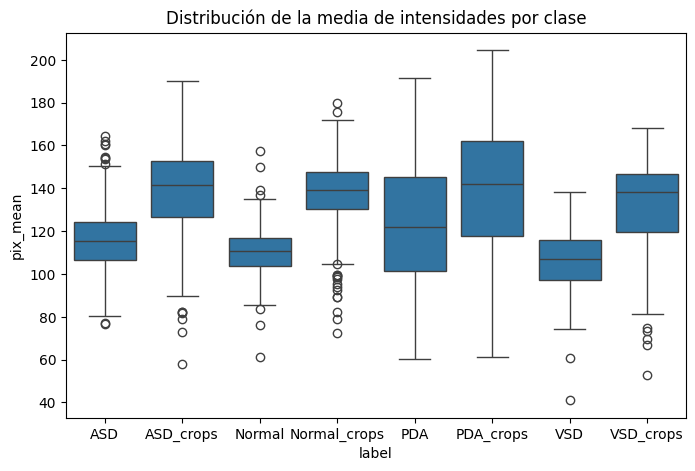

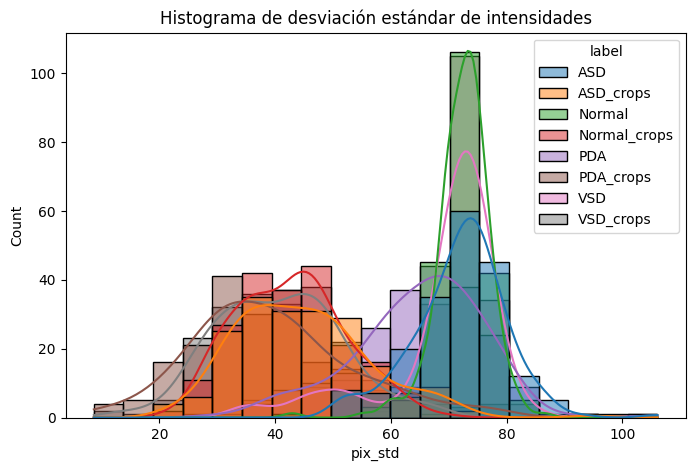

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt


# Boxplot por clase para la media de intensidades
plt.figure(figsize=(8,5))
sns.boxplot(data=intensity_features_df, x='label', y='pix_mean')
plt.title("Distribución de la media de intensidades por clase")
plt.show()

# Histograma de la desviación estándar
plt.figure(figsize=(8,5))
sns.histplot(data=intensity_features_df, x='pix_std', hue='label', kde=True)
plt.title("Histograma de desviación estándar de intensidades")
plt.show()

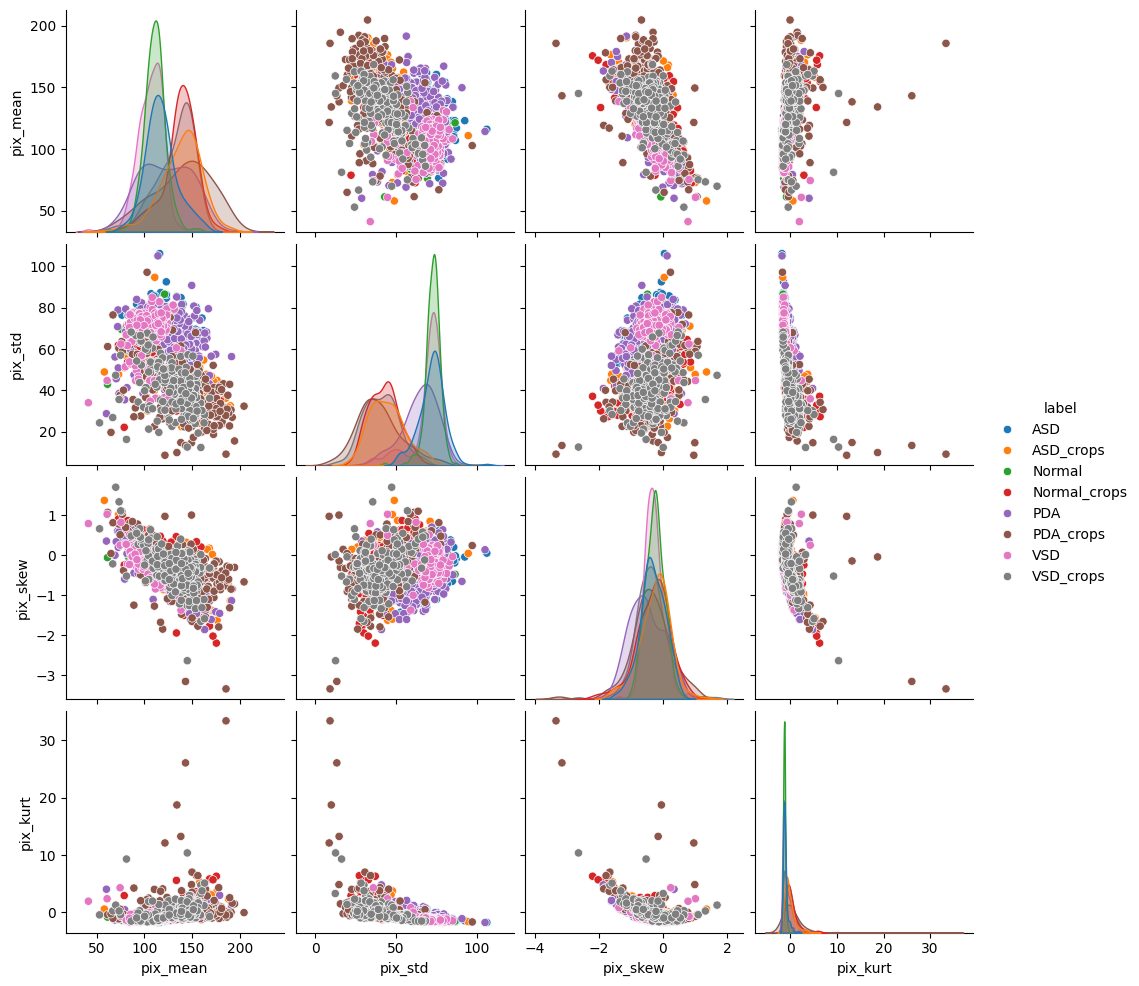

In [ ]:
# Pairplot para ver correlaciones
sns.pairplot(intensity_features_df[['pix_mean','pix_std','pix_skew','pix_kurt','label']], hue='label')
plt.show()

#### **Analisis de graficos**

1. Pairplot
- Vemos relaciones entre pix_mean, pix_std, pix_skew, pix_kurt.
- Se aprecian agrupaciones por clase: por ejemplo, PDA tiene valores de media y varianza más dispersos.
- Correlaciones claras: media vs. skew, media vs. kurt.
- Esto indica que las distribuciones de intensidad difieren entre clases, lo que puede ser útil para clasificación.<br>
<br>


2. Histograma de desviación estándar
- Cada clase tiene un rango característico de variabilidad en intensidades.
- Normal y ASD se concentran en desviaciones estándar alrededor de 70–75.
- PDA muestra mayor dispersión (más contrastes variados en sus imágenes).
- Esto confirma que el contraste promedio puede ser diferente según la cardiopatía.<br>
<br>


3. Boxplot de la media de intensidades <br>
- Las medias (pix_mean) varían por clase.
- PDA tiene distribuciones más amplias, mientras que ASD y Normal se concentran en valores más altos.
- Esto sugiere que el nivel de brillo promedio de las imágenes también es un factor discriminante.

### **Features de Textura GLCM**
<BR>


A continuacion calcularemos features para capturar la textura de la imagen, reconocer el como se distribuyen y se pueden repetir patrones de intesidades.


Usaremos la tecnica de procesamiento y analisis de imagenes llamada **GLCMs (gray level co-occurrence matrices)**. Mientras que los features anteriores (intensity_features) describía valores globales (media, varianza, brillo, contraste general), **esta tecnica analiza las relaciones entre pixeles vecinos, reconociendo posibles microestructuras de la imagen como, rigurosidad, suavidad, regularidades, etc.**


En imagenes medicas para el anlisis de rayos X o ecocardiagramas, la textura puede indicar diferencias en el tejido o estructuras anatomicas que puedan estar relacionadas con patologias.

Referencias Bilbliograficas:

- https://www.sciencedirect.com/science/article/abs/pii/S0098300417301164
- https://www.researchgate.net/publication/356257299_A_Features_Fusion_Approach_for_Neonatal_and_Pediatrics_Brain_Tumor_Image_Analysis_Using_Genetic_and_Deep_Learning_Techniques
- https://www.researchgate.net/publication/346727696_Covid19_Identification_from_Chest_X-ray_Images_using_Machine_Learning_Classifiers_with_GLCM_Features


**Las propiedades de textura que este metodo nos otorga son:**

- Contrast:
  - Diferencias entre locales de intensidad.
  - Si son valores altos son texturas con bordes marcados

- Dissmilarity: Diferencia promedio entre valores vecinos.
- Homogeneity
  - Que tan uniformes son las intensidades, si son valores altos significa que la textura es suave.

- ASM (Angular second moment): Uniformidad de la distribucion de tonos, si son valores altos significa que hay pocos tonos dominantes.

- Egergy: Raiz cuadrada del ASM, mide orden en la textura.

- Correlation: Correlacion entre pixeles vecinos, si son valores altos nos habla de un patron direccional o estructurado.

Obteninedo los siguientes vectores:
```
{
 'glcm_contrast_mean': valor , 'glcm_contrast_std': valor,
 'glcm_dissimilarity_mean': valor, 'glcm_dissimilarity_std': valor,
 'glcm_homogeneity_mean': valor, 'glcm_homogeneity_std': valor,
 'glcm_ASM_mean': valor, 'glcm_ASM_std': valor,
 'glcm_energy_mean': valor, 'glcm_energy_std': valor,
 'glcm_correlation_mean': valor, 'glcm_correlation_std': valor
}
```

Como interpretar los resultados:

- Contraste alto en una clase: Mostraria estructuras con bordes marcados o variaciones de intensidad.
- Homogenidad alta: areas suaves, poco detalle.
- Energy/ASM Alto: Texturas repetitivas o uniformes
- Correlacion alta: Patrones direccionales consistentes, ejemplo tejido organicos.


In [59]:
from skimage.feature import graycomatrix, graycoprops

In [60]:
def glcm_features(img, levels=32, dists=(1,2,4), angles=(0, np.pi/4, np.pi/2, 3*np.pi/4)):
    # cuantizar a "levels"
    imq = (img / (256/levels)).astype(np.uint8)
    glcm = graycomatrix(imq, distances=dists, angles=angles, levels=levels, symmetric=True, normed=True)
    props = ['contrast','dissimilarity','homogeneity','ASM','energy','correlation']
    feats = {}
    for p in props:
        vals = graycoprops(glcm, p).ravel()
        feats[f'glcm_{p}_mean'] = float(vals.mean())
        feats[f'glcm_{p}_std']  = float(vals.std())
    return feats


all_features = []
feats = []

for path in df['image_path']:
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    feats = glcm_features(img)
    feats['image_path'] = path
    all_features.append(feats)

glcm_features_df = pd.DataFrame(all_features)

In [62]:
# Unir el nuevo feature df con las etiquetas
glcm_features_df = glcm_features_df.merge(df[['image_path','label']], on='image_path')

In [64]:
# Guardar resultados
glcm_features_df.to_csv("/content/drive/MyDrive/CARDIOS - PROYECTO INTEGRADOR/features/glcm_features_df.csv", index=False)

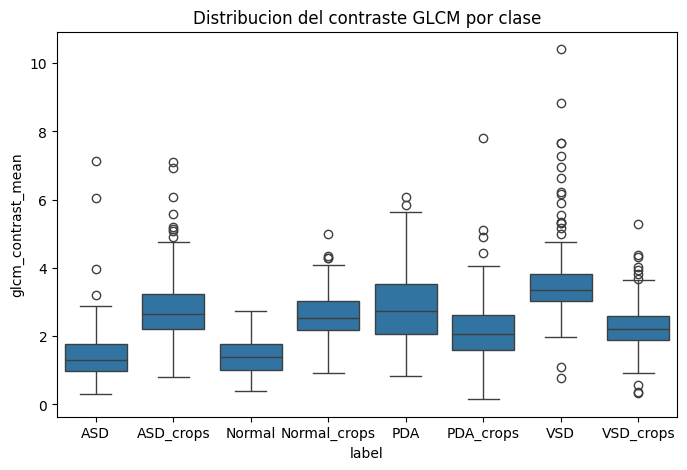

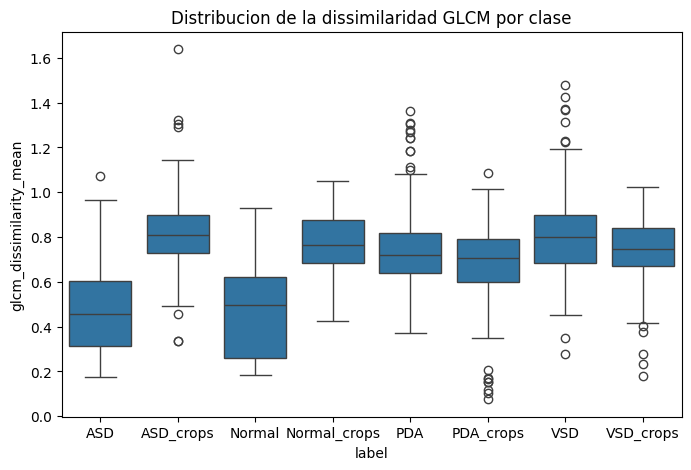

In [ ]:
# Boxplot por variable, analisis de las distribuciones por variable
plt.figure(figsize=(8,5))
sns.boxplot(data=glcm_features_df, x='label', y='glcm_contrast_mean')
plt.title("Distribucion del contraste GLCM por clase")
plt.show()

plt.figure(figsize=(8,5))
sns.boxplot(data=glcm_features_df, x='label', y='glcm_dissimilarity_mean')
plt.title("Distribucion de la dissimilaridad GLCM por clase")
plt.show()

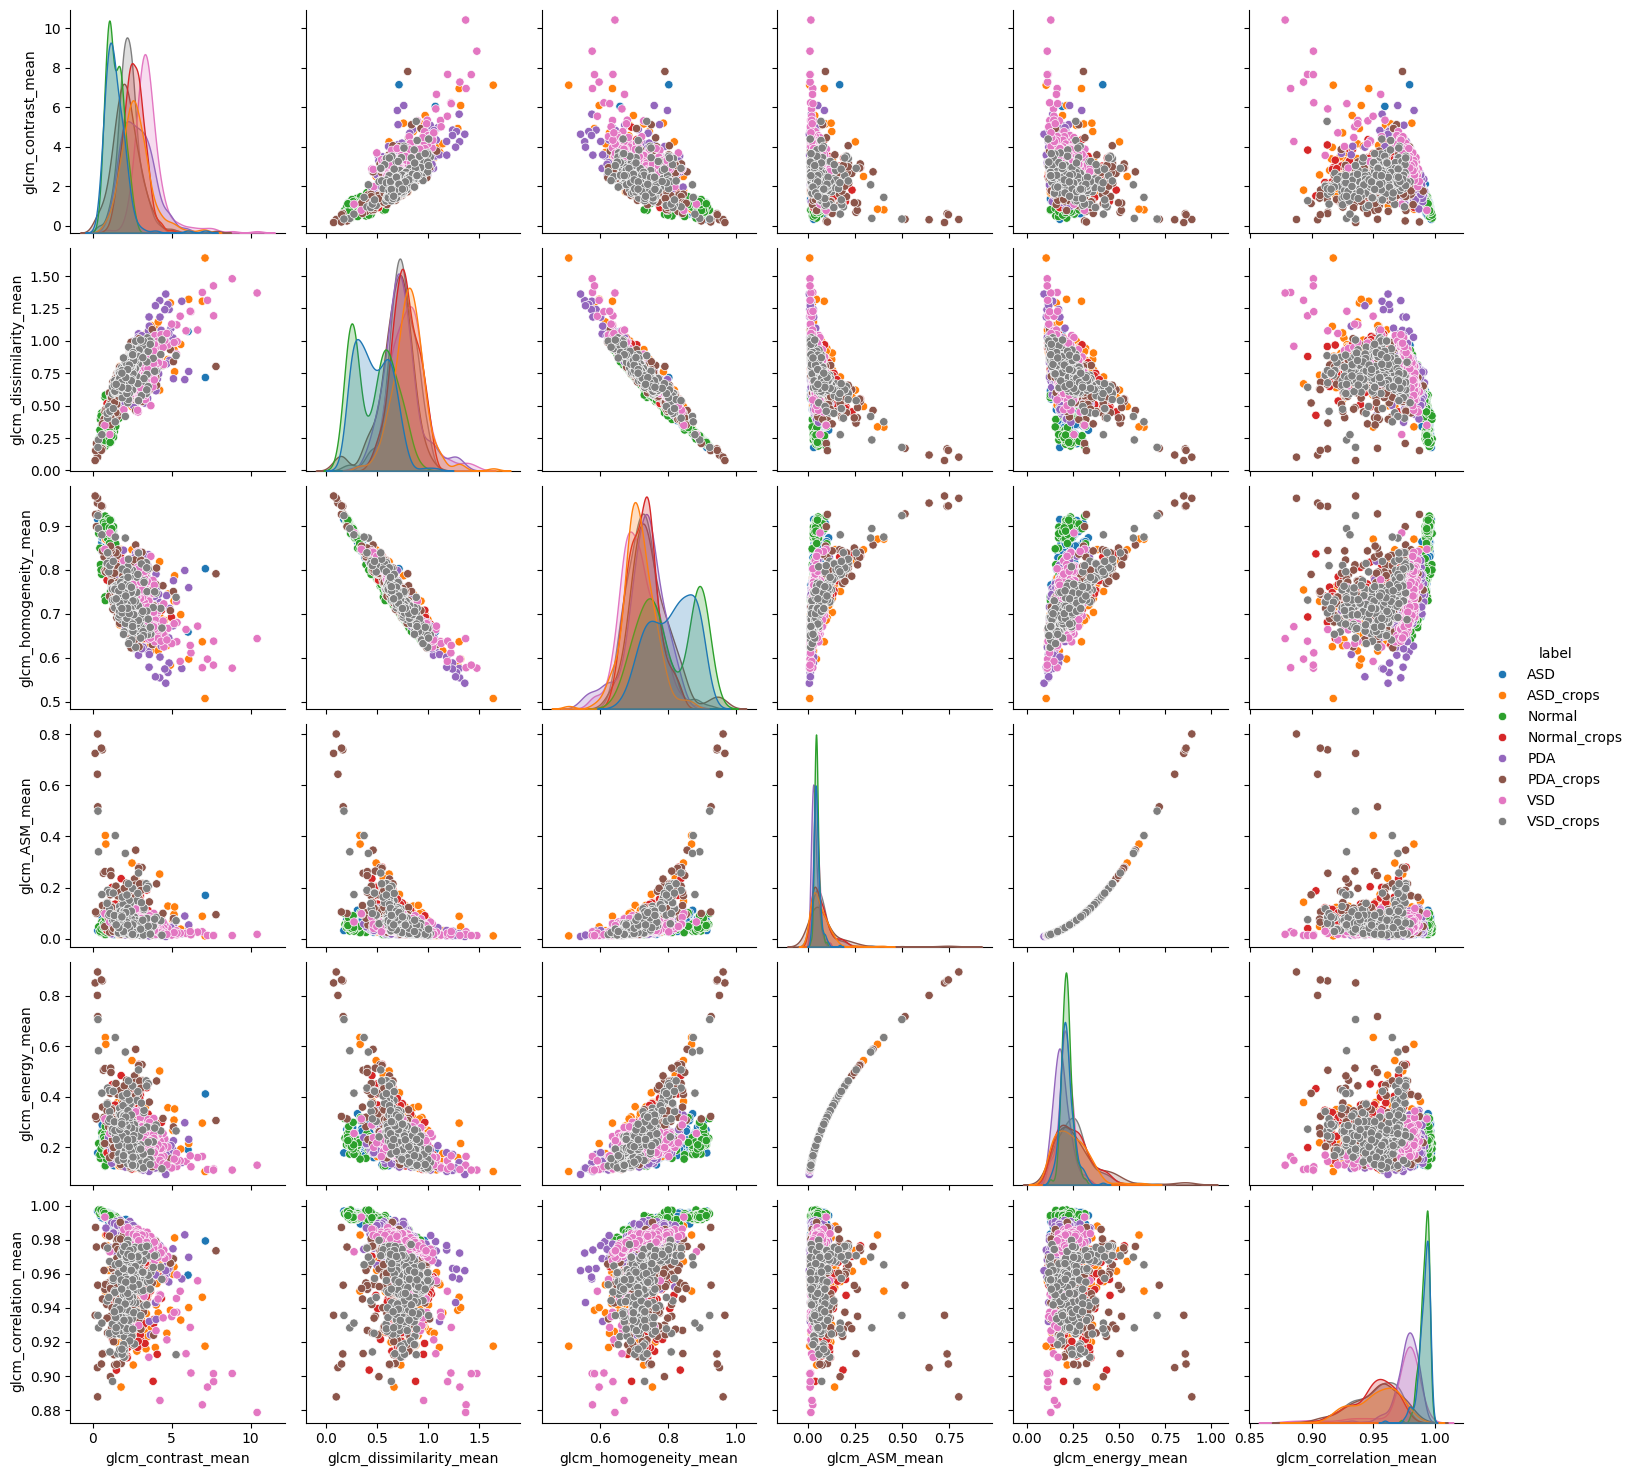

In [ ]:
# Pairplot, visualizacion multivariada para ver correlaciones, relacinoes entre features
sns.pairplot(glcm_features_df[['glcm_contrast_mean','glcm_dissimilarity_mean','glcm_homogeneity_mean','glcm_ASM_mean','glcm_energy_mean','glcm_correlation_mean','label']], hue='label')
plt.show()

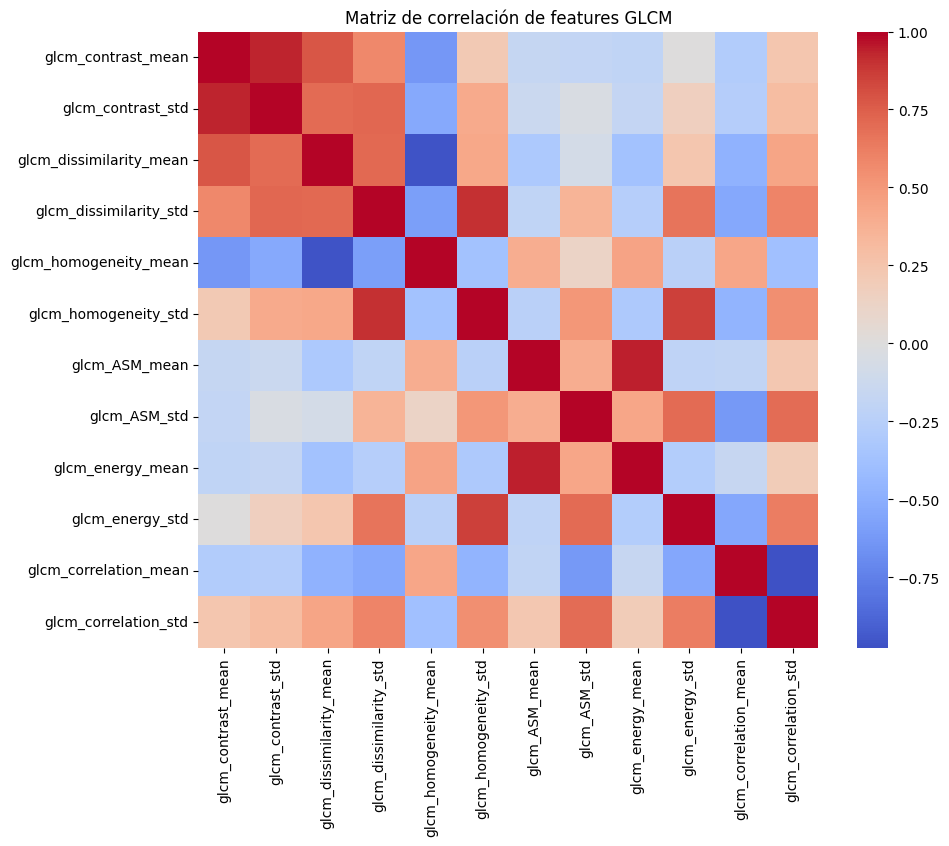

In [ ]:
corr = glcm_features_df.drop(columns=['image_path','label']).corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr, cmap='coolwarm', center=0)
plt.title("Matriz de correlación de features GLCM")
plt.show()

#### **Analisis de graficos**

1. Boxplot - Media de contraste "glcm_contrast_mean"
- Esta caracteristica nos mide la variacion local de intesidades, diferencias con pixeles vecinos.
- PDA y VSD muestran contrastes más altos, indicando que esas imágenes tienen más heterogeneidad o estructuras con bordes pronunciados.
- ASD y Normal tienen contraste bajo, lo que sugiere regiones más homogéneas.

El contraste GLCM podría ser un buen descriptor discriminante entre clases, ya que hay separación visible entre Normal/ASD y PDA/VSD.
<br>
<br>


2. Boxplot - Dissimilarity "glcm_dissimilarity_mean"
- Mide la diferencia promedio entre pares de pixeles vecinos.
- Al igual que en la medio de contraste, PDA y VSD presentan valores mas altos, lo que indica irregularidades en sus texturas.
-  Normal y ASD se mantienen bajos, indicaria texturas suaves.

La disimilitud confirma la tendencia vista en el contraste, la cual es que hay más variación estructural en imágenes para las clases PDA y VSD.
<br>
<br>


3. Pairplot — Relaciones entre features GLCM
En este grafico se muestran las correlaciones entre los descriptores obtenidos.
- Contrast y dissimilarity están positivamente correlacionados (ambos miden variación).
- Homogeneity tiene correlación negativa con contrast y dissimilarity, o sea que cuanto más homogénea la textura, menor contraste.
- ASM y energy están muy correlacionadas, esto es de esperarse ya que ASM se calcula con el valor de energy y ambas miden uniformidad de la textura.
- Correlation_mean parece más independiente, capturando patrones direccionales o alineaciones.
- PDA y VSD forman nubes mas dispersas, posiblemente sea por que tienen texturas mas variadas.
- ASD y Normal estan mas agrupadas, posiblemente por texturas mas consistentes.


El espacio de texturas GLCM muestra ciertos patrones de agrupamiento por clase (mencionados anteriormente), lo cual sugiere que estas features son útiles para clasificación.
<br>
<br>


4. Heatmap - Matriz Correlacion Features GLCM
- glcm_contrast_mean y glcm_dissimilarity_mean tienen alta correlación (≈0.9), por lo que probablemente solo necesites una de ellas en el modelo final.
- ASM_mean y energy_mean también son altamente correlacionadas (≈1.0). Puedes eliminar una de ellas para evitar multicolinealidad.
- homogeneity tiene correlaciones negativas con contrast y dissimilarity — complementaria.

In [ ]:
# Opcional, si queremos combinar con el df de los features de intensidad
# combined_df = pd.merge(features_df, glcm_df, on=['image_path','label'])


### **Features radiograficos Vesselnes Frangi - Intesidades vasculares por regiones**
<BR>


El algoritmo frangi vesselness que ayuda a resaltar y abstraer las estructuras tubulares de los vasos sanguineos en rayos x, siendo usada para detectar aumento de trama vascular que puede ser provocado por hiperflujo pulmonar (a tomar encuenta en las clases pda  vsd). Tambien ayudaria a capturar patrones asosiados a sobrecirculacion, asimetrias u oligemia


Pasos del algoritmo:
- Usa el filtro Frangi para medir la “vesselness”: cuán vasculares o tubulares son las estructuras (detecta vasos pulmonares).
- Divide cada pulmón en una región perihiliar (cerca del mediastino) y periférica (hacia los bordes).
- Calcula estadísticos de esas regiones (media, desviación estándar, percentiles).
<br>

Que informacion trata de capturas el algoritmo?
- El flujo pulmonar aumentado (plethora) o reducido cambia la densidad y el contraste de las marcas vasculares.
- El filtro Frangi simula detectar vasos, por lo que sus valores se correlacionan con el flujo.
<br>

Como podriamos interpretaar los valores?
- PDA y VSD: flujo pulmonar aumentado, valores de vesselness más altos, sobre todo perihiliares.
- ASD: flujo derecho aumentado, patrón diferente (prominencia arterial pulmonar derecha).
- Normal: distribución vascular equilibrada.
<br>

In [65]:
from skimage import exposure
from skimage.filters import frangi, threshold_otsu
from skimage.morphology import remove_small_objects, binary_opening, binary_closing, disk
from skimage.measure import label, regionprops
from scipy.ndimage import distance_transform_edt

In [66]:
IMG_SIZE = (320, 320)  # tamaño consistente

def load_gray(path, size=IMG_SIZE):
    """Lee imagen RX en gris, reescala y normaliza con CLAHE a [0,1]."""
    im = Image.open(path).convert('L')
    if size:
        im = im.resize(size, Image.BILINEAR)
    x = np.array(im, dtype=np.float32)
    x = exposure.equalize_adapthist(x, clip_limit=0.03)  # mejora contraste
    return x  # [0,1]

def perihilar_peripheral_masks(lung_mask, center_frac=0.40):
    """
    Divide un pulmón en región perihiliar (centro geométrico) y periférica (corteza)
    usando la distancia al borde del pulmón.
    """
    if lung_mask.sum() == 0:
        return np.zeros_like(lung_mask), np.zeros_like(lung_mask)
    D = distance_transform_edt(lung_mask)
    thr = center_frac * D.max()
    peri = (D > thr)
    peri &= lung_mask
    peri = remove_small_objects(peri, 128)
    peripheral = lung_mask & (~peri)
    return peri, peripheral

def region_stats(img, mask):
    """Promedio, desviación y percentiles dentro de una máscara."""
    if mask.sum() == 0:
        return dict(mean=np.nan, std=np.nan, p50=np.nan, p90=np.nan)
    vals = img[mask]
    return dict(
        mean=float(vals.mean()),
        std=float(vals.std()),
        p50=float(np.percentile(vals, 50)),
        p90=float(np.percentile(vals, 90)),
    )


In [67]:
# Generacion de mascaras pulmonares derecha e izquierda

def segment_lungs_rough(x):
    """
    Segmentación simple de pulmones:
    - Umbral sobre imagen invertida
    - Limpieza morfológica
    - Conserva las 2 regiones más grandes (izq/der)
    """
    x_inv = 1.0 - x
    t = threshold_otsu(x_inv)
    lung_mask = x_inv > t

    lung_mask = binary_opening(lung_mask, footprint=disk(3))
    lung_mask = binary_closing(lung_mask, footprint=disk(5))
    lung_mask = remove_small_objects(lung_mask, min_size=500)

    lab = label(lung_mask)
    props = sorted(regionprops(lab), key=lambda r: r.area, reverse=True)
    keep = np.zeros_like(x, bool)
    for r in props[:2]:
        keep[lab == r.label] = True
    lung_mask = keep

    h, w = lung_mask.shape
    mid = w // 2
    mask_l = np.zeros_like(lung_mask); mask_r = np.zeros_like(lung_mask)
    mask_l[:, :mid] = lung_mask[:, :mid]
    mask_r[:, mid:] = lung_mask[:, mid:]

    lab_l = label(mask_l); lab_r = label(mask_r)
    if lab_l.max() > 0:
        comp_l = max(regionprops(lab_l), key=lambda r: r.area)
        mask_l = lab_l == comp_l.label
    if lab_r.max() > 0:
        comp_r = max(regionprops(lab_r), key=lambda r: r.area)
        mask_r = lab_r == comp_r.label

    return mask_l, mask_r, lung_mask


In [ ]:
def vesselness_features(x, mask_l, mask_r, lung_mask,scale_range=(1,3), scale_step=2): #, center_frac=0.40):
    """
    x: imagen [0,1]
    mask_l, mask_r: máscaras booleanas de pulmón izquierdo y derecho
    Devuelve estadísticas de Frangi por pulmón y por subregiones (perihiliar/periférica),
    más cocientes perihiliar/periférico (L y R).
    """
    # 1) Mapa de vesselness (Frangi)
    fr = frangi(x, scale_range=scale_range, scale_step=scale_step)  # ~[0,1]

    # 2) Subregiones por pulmón
    L_peri, L_periph = perihilar_peripheral_masks(mask_l)#, center_frac=center_frac)
    R_peri, R_periph = perihilar_peripheral_masks(mask_r) #, center_frac=center_frac)

    # 3) Estadísticos - Promedios por region
    feats = {}
    feats.update({f'frangi_L_{k}': v for k, v in region_stats(fr, mask_l).items()})
    feats.update({f'frangi_R_{k}': v for k, v in region_stats(fr, mask_r).items()})

    feats.update({f'frangi_L_perihilar_{k}': v for k, v in region_stats(fr, L_peri).items()})
    feats.update({f'frangi_L_peripheral_{k}': v for k, v in region_stats(fr, L_periph).items()})
    feats.update({f'frangi_R_perihilar_{k}': v for k, v in region_stats(fr, R_peri).items()})
    feats.update({f'frangi_R_peripheral_{k}': v for k, v in region_stats(fr, R_periph).items()})

    # Cocientes útiles (combinaciones de características)
    # 4) Cocientes perihiliar/periférico (flujo central vs periférico)
    def safe_ratio(a, b):
        return float(a / b) if (b is not None and b != 0 and not np.isnan(b)) else np.nan

    feats['ratio_frangi_perihilar_over_peripheral_L'] = safe_ratio(
        feats['frangi_L_perihilar_mean'], feats['frangi_L_peripheral_mean'])
    feats['ratio_frangi_perihilar_over_peripheral_R'] = safe_ratio(
        feats['frangi_R_perihilar_mean'], feats['frangi_R_peripheral_mean'])

    return feats #, fr, (L_peri, L_periph, R_peri, R_periph)


In [ ]:
def compute_vesselness_df(df_images, label_col='label', frangi_scale=(1,3), center_frac=0.40):
    rows = []
    for path, label in zip(df_images['image_path'], df_images[label_col]):
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            print(f"⚠️ No se pudo leer: {path}")
            continue

        # Normalización a [0,1]
        x = img.astype(np.float32)
        x = (x - x.min()) / max(1e-6, (x.max() - x.min()))

        # Segmentación pulmonar
        mask_l, mask_r, lung_mask = segment_lungs_rough(x)

        # Extraer features
        feats = vesselness_features(x, mask_l, mask_r,
                                    frangi_scale=frangi_scale,
                                    center_frac=center_frac)
        feats['image_path'] = path
        feats['label'] = label
        rows.append(feats)

    return pd.DataFrame(rows)

In [ ]:
vess_crop = compute_vesselness_df(df_crop)
# vess_og   = compute_vesselness_df(df_og)

print("Features de vesselness calculadas")

/tmp/ipython-input-4105081615.py:9: UserWarning: Use keyword parameter `sigmas` instead of `scale_range` and `scale_range` which will be removed in version 0.17.
  fr = frangi(x, scale_range=scale_range, scale_step=scale_step)  # ~[0,1]


Features de vesselness calculadas


In [ ]:
# Guardar resultados
vess_crop.to_csv("/content/drive/MyDrive/CARDIOS - PROYECTO INTEGRADOR/features/vesselness_features_crop.csv", index=False)
# vess_og.to_csv("/content/vesselness_features_og.csv", index=False)

### **Analisis de visual de features**

In [ ]:
vess_crop_df = vess_crop.copy()

In [72]:
vess_crop_df = pd.read_csv("/content/drive/MyDrive/CARDIOS - PROYECTO INTEGRADOR/features/vesselness_features_crop.csv")

#### **Analisis visual univariado -  Boxplots por clase**

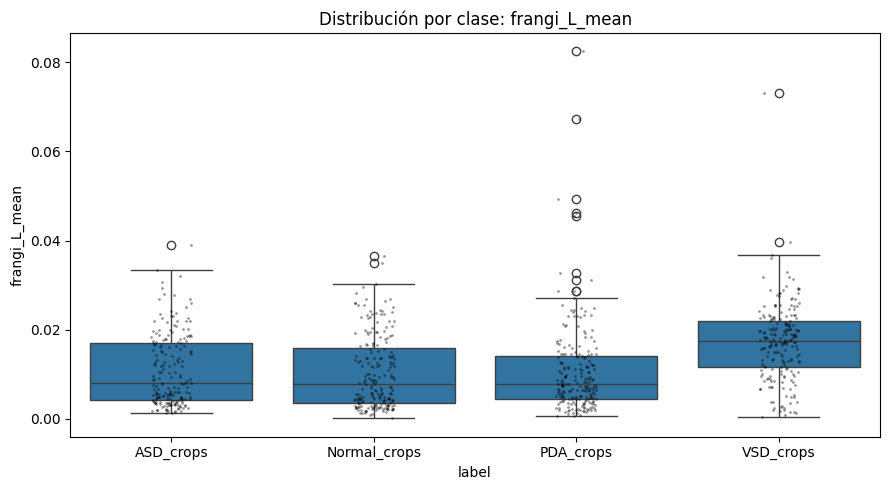

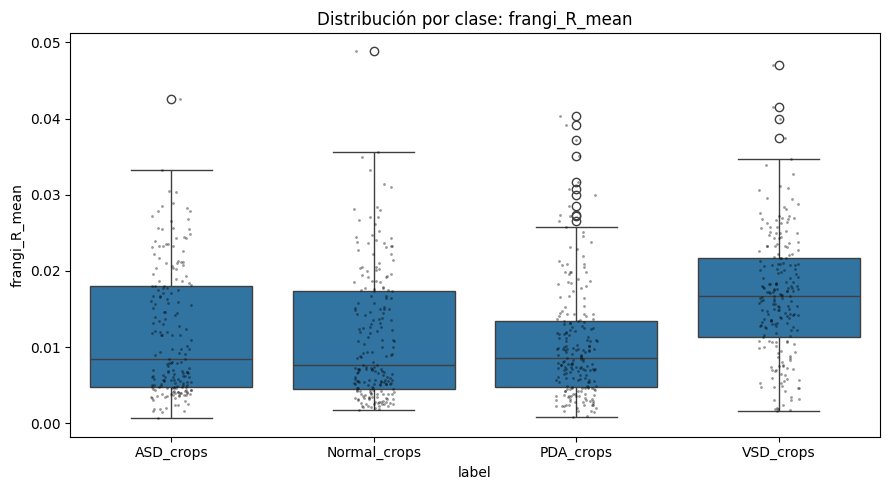

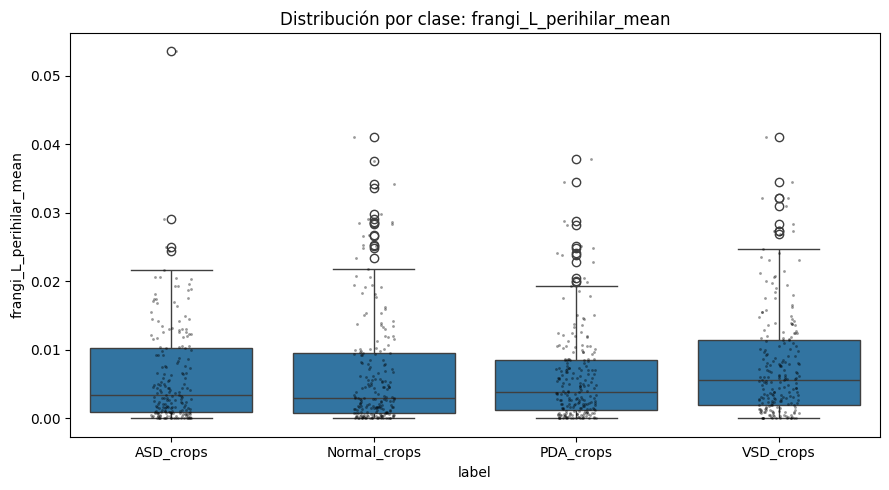

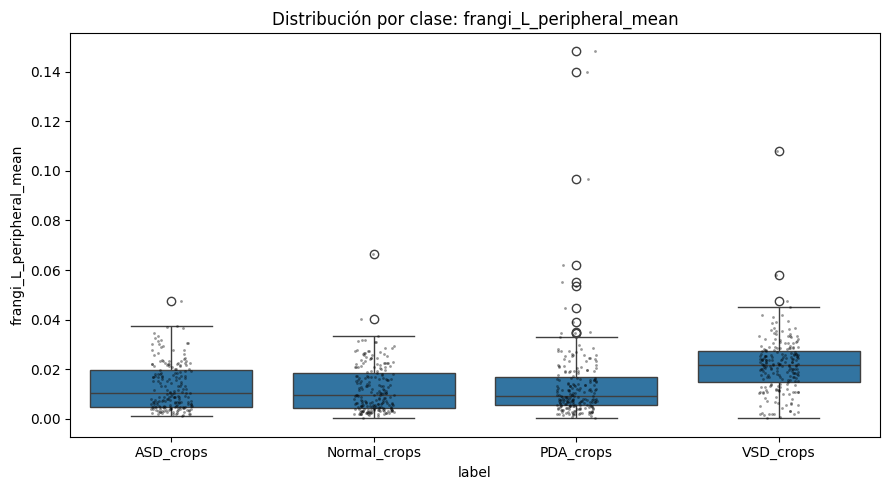

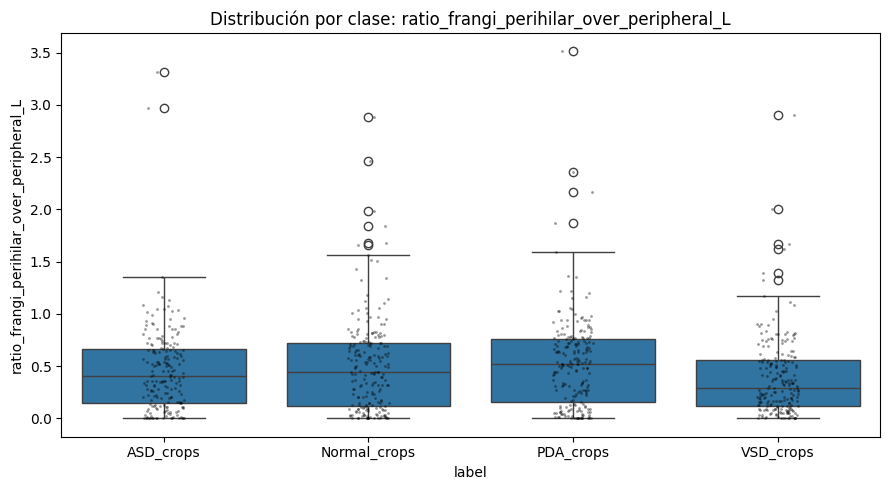

In [ ]:
vess_crop_df = vess_crop.copy()
cols_univ = [
    'frangi_L_mean','frangi_R_mean',
    'frangi_L_perihilar_mean','frangi_L_peripheral_mean',
    'ratio_frangi_perihilar_over_peripheral_L'
]

for col in cols_univ:
    plt.figure(figsize=(9,5))
    sns.boxplot(data=vess_crop_df, x='label', y=col)
    sns.stripplot(data=vess_crop_df, x='label', y=col, color='k', size=2, alpha=0.4)
    plt.title(f"Distribución por clase: {col}")
    plt.tight_layout()
    plt.show()

#### **Pairplot  - Relaciones entre features y distribuciones**

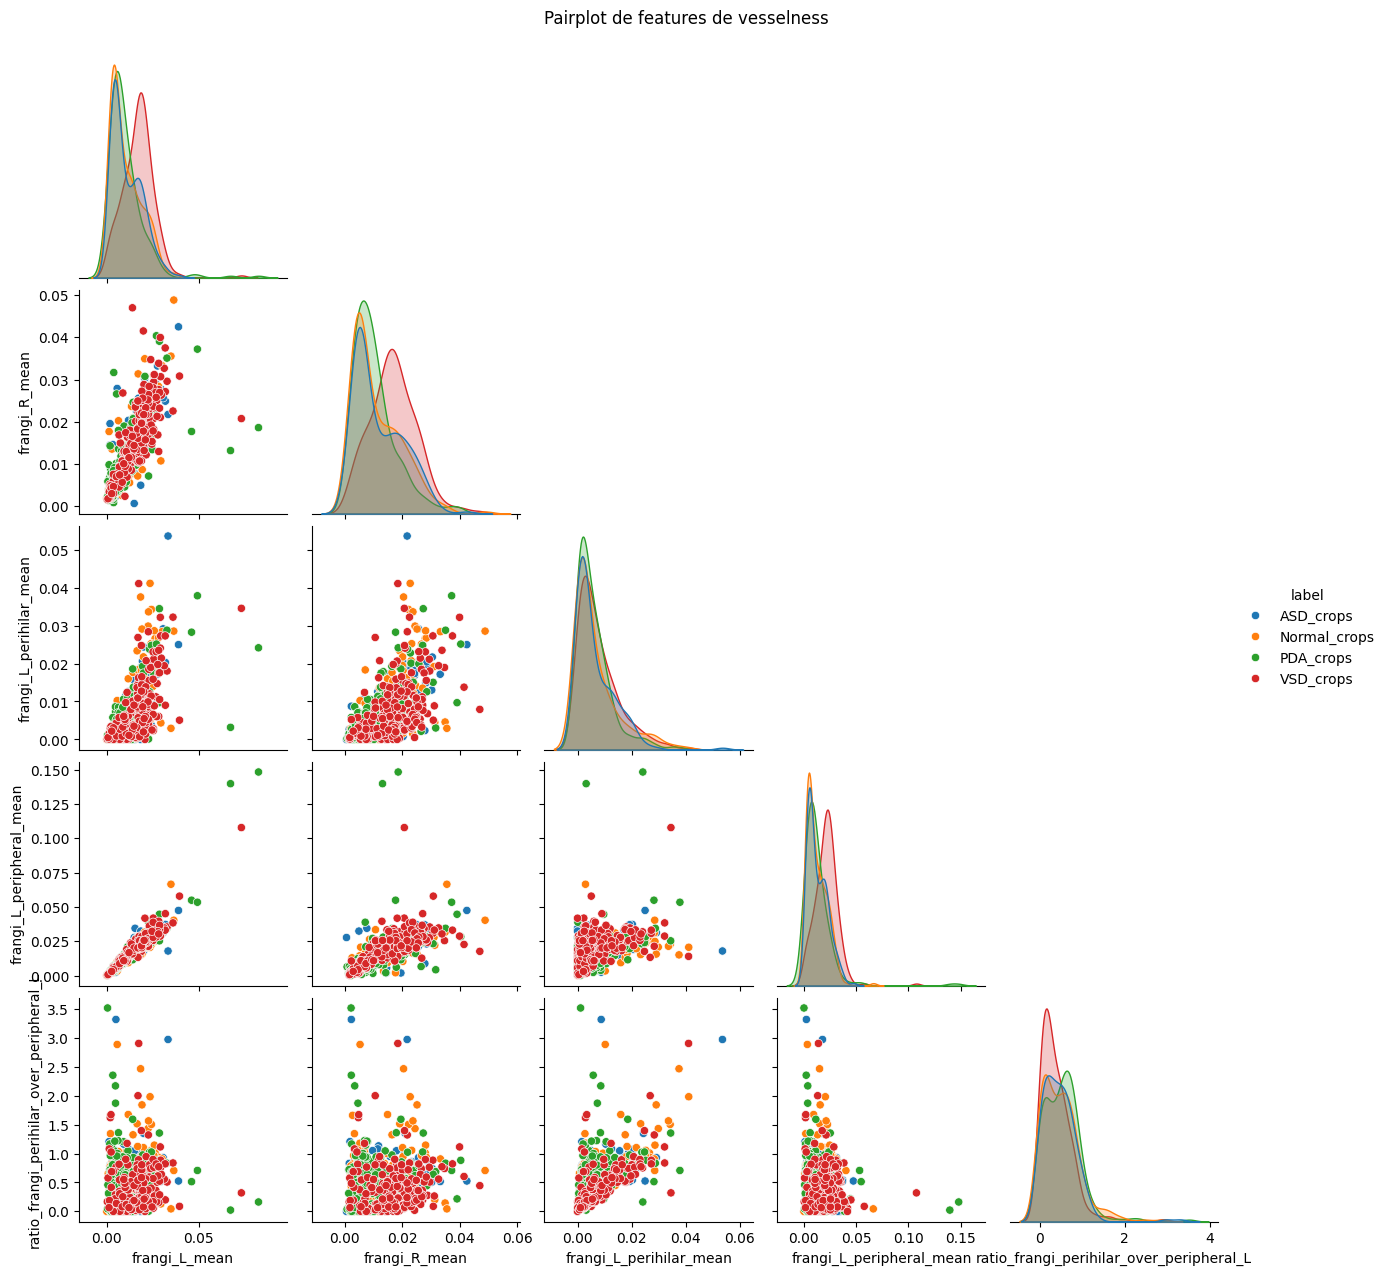

In [ ]:
subset = vess_crop_df[[
    'frangi_L_mean','frangi_R_mean',
    'frangi_L_perihilar_mean','frangi_L_peripheral_mean',
    'ratio_frangi_perihilar_over_peripheral_L','label'
]].dropna()

sns.pairplot(subset, hue='label', diag_kind='kde', corner=True)
plt.suptitle("Pairplot de features de vesselness", y=1.02)
plt.show()


#### **Correlaciones - Heatmap**

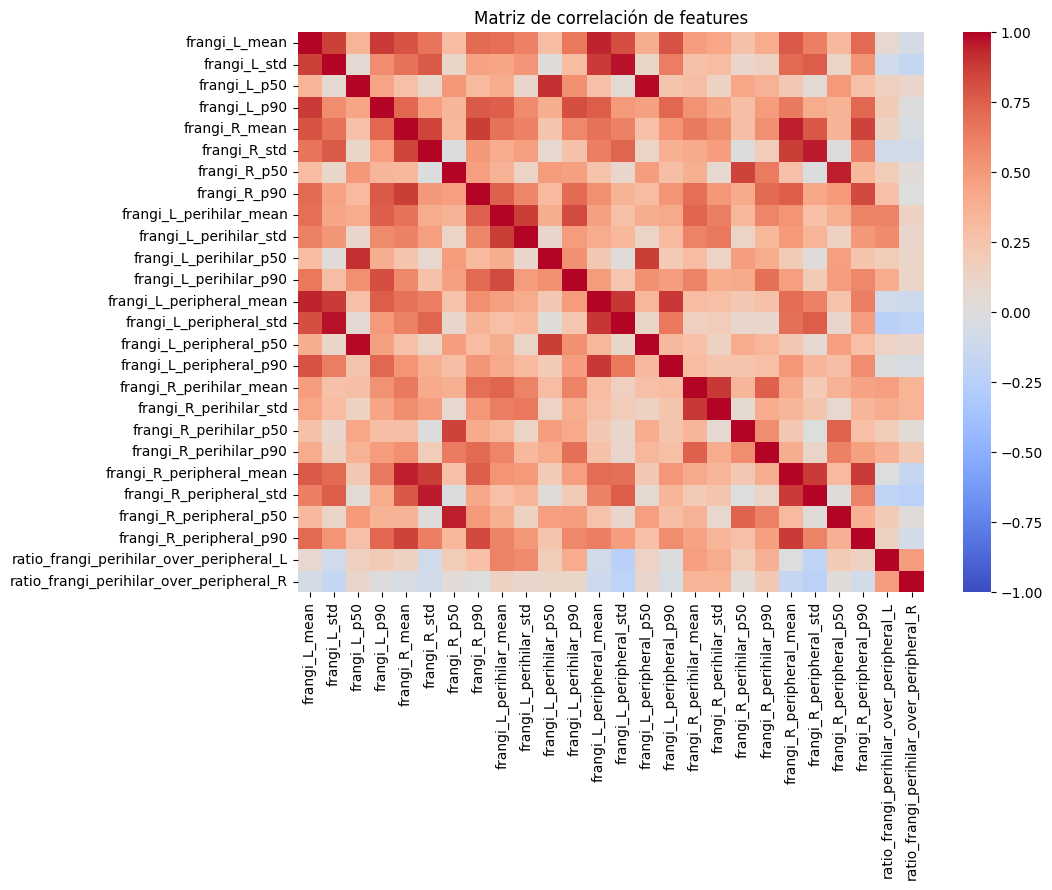

In [ ]:
num_cols = vess_crop_df.select_dtypes(include=['float','int']).columns
corr = vess_crop_df[num_cols].corr()

plt.figure(figsize=(11,9))
sns.heatmap(corr, cmap='coolwarm', center=0, vmax=1, vmin=-1)
plt.title("Matriz de correlación de features")
plt.tight_layout()
plt.show()


In [ ]:
vess_crop_df = vess_crop.copy()

### **Perihiliar vs Periférico (sanity check anatómico)**

El filtro Frangi calcula un valor entre 0 y 1 para cada píxel, que indica qué tan “tubular” parece (como un vaso sanguíneo).
Por lo que:
- Valores altos representan estructuras vasculares.
- valores bajos representan, regiones planas o sin patrones tubulares.

En una radiografía torácica normal:
- Las estructuras vasculares centrales (perihiliares) son más densas y ramificadas, mayor vesselness.
- Las zonas periféricas tienen menos vasos, menor vesselness.

Por eso, se espera que los puntos caigan por encima de la diagonal y = x (la línea discontinua).

- Si están por encima, el vesselness central (perihiliar) es mayor que el periférico (esperado fisiológicamente).
- Si caen por debajo, el periférico supera al central (inusual, puede indicar ruido, segmentación mala o patrón patológico).
<br>

Al ver el grafico:
- Si NORMAL se agrupa sobre la diagonal, correcto, hay más vasos en el centro.
- Si una clase patológica (ej. PDA) tiene muchos puntos debajo de la diagonal, puede significar redistribución vascular o hiperflujo periférico, lo cual tiene sentido clínico en algunas cardiopatías congénitas.
- Si todo el conjunto se desplaza hacia arriba, imágenes con vasos muy marcados (quizá exposición alta o contraste alto).
- Si está muy disperso, segmentaciones o intensidades heterogénea

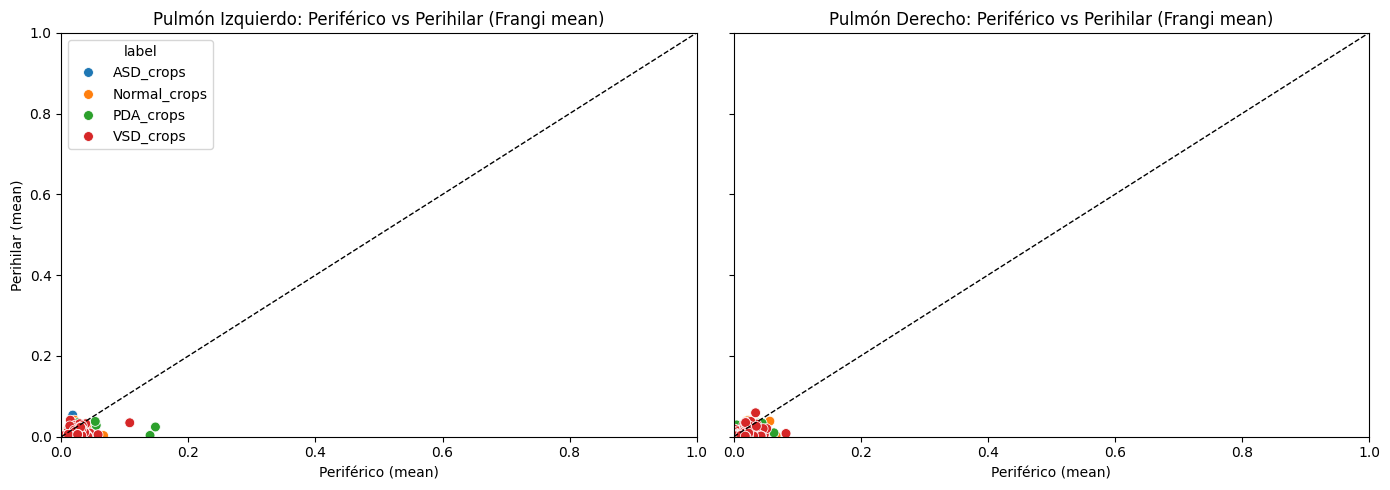

In [ ]:
def plot_peri_vs_periph_both(features_df):
    # Filtra filas válidas
    df = features_df.copy()
    cols_needed = [
        'frangi_L_peripheral_mean','frangi_L_perihilar_mean',
        'frangi_R_peripheral_mean','frangi_R_perihilar_mean','label'
    ]
    df = df.dropna(subset=cols_needed)

    fig, axes = plt.subplots(1, 2, figsize=(14,5), sharex=True, sharey=True)

    # Pulmón Izquierdo
    sns.scatterplot(
        data=df,
        x='frangi_L_peripheral_mean',
        y='frangi_L_perihilar_mean',
        hue='label', s=50, ax=axes[0]
    )
    axes[0].plot([0,1],[0,1],'k--',linewidth=1)
    axes[0].set_xlim(0,1); axes[0].set_ylim(0,1)
    axes[0].set_title("Pulmón Izquierdo: Periférico vs Perihilar (Frangi mean)")
    axes[0].set_xlabel("Periférico (mean)")
    axes[0].set_ylabel("Perihilar (mean)")

    # Pulmón Derecho
    sns.scatterplot(
        data=df,
        x='frangi_R_peripheral_mean',
        y='frangi_R_perihilar_mean',
        hue='label', s=50, ax=axes[1], legend=False  # evitar duplicar leyenda
    )
    axes[1].plot([0,1],[0,1],'k--',linewidth=1)
    axes[1].set_xlim(0,1); axes[1].set_ylim(0,1)
    axes[1].set_title("Pulmón Derecho: Periférico vs Perihilar (Frangi mean)")
    axes[1].set_xlabel("Periférico (mean)")
    axes[1].set_ylabel("Perihilar (mean)")

    plt.tight_layout()
    plt.show()

plot_peri_vs_periph_both(vess_crop_df)

La figura muestra la relación entre la media del vesselness en las regiones perihiliar y periférica de ambos pulmones. Se observa que la mayoría de las imágenes presentan valores bajos de vesselness (≈0–0.1) y que los puntos se concentran ligeramente por encima de la diagonal, lo que indica una mayor densidad vascular en la zona perihiliar en comparación con la periférica. Este comportamiento es anatómicamente coherente con la distribución normal de los vasos pulmonares.

No se aprecia una separación clara entre clases, lo cual es esperado en este análisis de coherencia fisiológica, pero los resultados confirman que el filtro Frangi y las máscaras segmentadas responden correctamente al patrón anatómico esperado.

Francisco

## 4. Evaluación de la calidad de las características (Feature Evaluation)

* Métricas de separabilidad (ej. ANOVA F-score, mutual information entre características y etiquetas).
* Importancia de características en modelos de prueba rápida (árboles de decisión, random forest).
* Visualización en 2D de embeddings para verificar separabilidad entre clases.

### Normalizacion de caracteristicas

In [77]:
from sklearn.preprocessing import MinMaxScaler
from functools import reduce

# Unir todos los DataFrames por image_path y label
dfs = [intensity_features_df, glcm_features_df, vess_crop_df]
features_df = reduce(lambda l, r: pd.merge(l, r, on=['image_path','label'], how='outer'), dfs)

# Filtrar solo columnas numéricas
num_cols = features_df.select_dtypes(include=['float', 'int']).columns

# Escalar 0-1
scaler = MinMaxScaler()
features_df[num_cols] = scaler.fit_transform(features_df[num_cols])

print("Features combinados y normalizados (0–1):")
print(features_df.shape)
features_df.head()


Features combinados y normalizados (0–1):
(1656, 51)


pix_mean  pix_std  pix_skew  pix_kurt  pix_p1  pix_p5  pix_p25  pix_p50  \
0       NaN      NaN       NaN       NaN     NaN     NaN      NaN      NaN   
1       NaN      NaN       NaN       NaN     NaN     NaN      NaN      NaN   
2       NaN      NaN       NaN       NaN     NaN     NaN      NaN      NaN   
3       NaN      NaN       NaN       NaN     NaN     NaN      NaN      NaN   
4       NaN      NaN       NaN       NaN     NaN     NaN      NaN      NaN   

   pix_p75  pix_p95  ...  frangi_R_perihilar_mean frangi_R_perihilar_std  \
0      NaN      NaN  ...                 0.153052               0.129737   
1      NaN      NaN  ...                 0.008121               0.014312   
2      NaN      NaN  ...                 0.259947               0.183077   
3      NaN      NaN  ...                 0.002851               0.027649   
4      NaN      NaN  ...                 0.132224               0.138364   

  frangi_R_perihilar_p50  frangi_R_perihilar_p90  frangi_R_peripheral_mean  \
0               0.000000                0.200361                  0.223060   
1               0.000000                0.000000                  0.473955   
2               0.246332                0.351291                  0.335933   
3               0.000000                0.000128                  0.099078   
4               0.000000                0.160146                  0.328913   

   frangi_R_peripheral_std  frangi_R_peripheral_p50  frangi_R_peripheral_p90  \
0                 0.230434                 0.012671                 0.152471   
1                 0.513603                 0.000000                 0.247454   
2                 0.278355                 0.201801                 0.226749   
3                 0.215795                 0.000000                 0.005084   
4                 0.367882                 0.005031                 0.199190   

   ratio_frangi_perihilar_over_peripheral_L  \
0                                  0.270687   
1                                  0.058626   
2                                  0.181026   
3                                  0.000378   
4                                  0.383499   

   ratio_frangi_perihilar_over_peripheral_R  
0                                  0.026114  
1                                  0.000662  
2                                  0.029726  
3                                  0.001059  
4                                  0.015437  

[5 rows x 51 columns]

### Métricas de separabilidad (ANOVA F-score y Mutual Information)

In [78]:
from sklearn.feature_selection import f_classif, mutual_info_classif
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

X = features_df[num_cols].fillna(0)
y = features_df['label']

# Calcular F-score y MI
f_values, p_values = f_classif(X, y)
mi_values = mutual_info_classif(X, y, random_state=42)

# Crear DataFrame resumen
feature_eval = pd.DataFrame({
    'Feature': num_cols,
    'F_score': f_values,
    'p_value': p_values,
    'Mutual_Info': mi_values
}).sort_values('F_score', ascending=False)

# Mostrar top 15
display(feature_eval.head(15))

Feature      F_score  p_value  Mutual_Info
21    glcm_correlation_mean  8862.873015      0.0     0.936895
10                  pix_p99  5116.317884      0.0     0.741266
9                   pix_p95  4405.006371      0.0     0.757944
8                   pix_p75  3870.647488      0.0     0.731747
1                   pix_std  2522.470737      0.0     0.762421
7                   pix_p50  2198.130821      0.0     0.735659
0                  pix_mean  1981.707504      0.0     0.785598
2                  pix_skew  1755.443319      0.0     0.738827
15    glcm_homogeneity_mean  1460.863257      0.0     0.817842
19         glcm_energy_mean  1030.948527      0.0     0.734219
12        glcm_contrast_std  1022.049016      0.0     0.945120
11       glcm_contrast_mean   905.898374      0.0     0.910359
14   glcm_dissimilarity_std   901.860018      0.0     0.990519
13  glcm_dissimilarity_mean   887.014712      0.0     0.838162
16     glcm_homogeneity_std   597.109789      0.0     0.863988

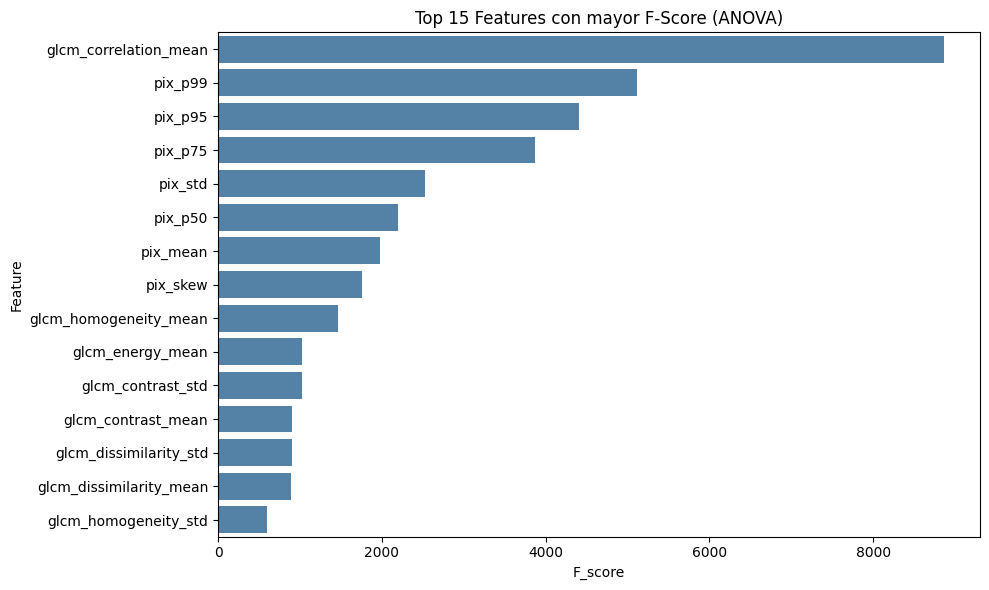

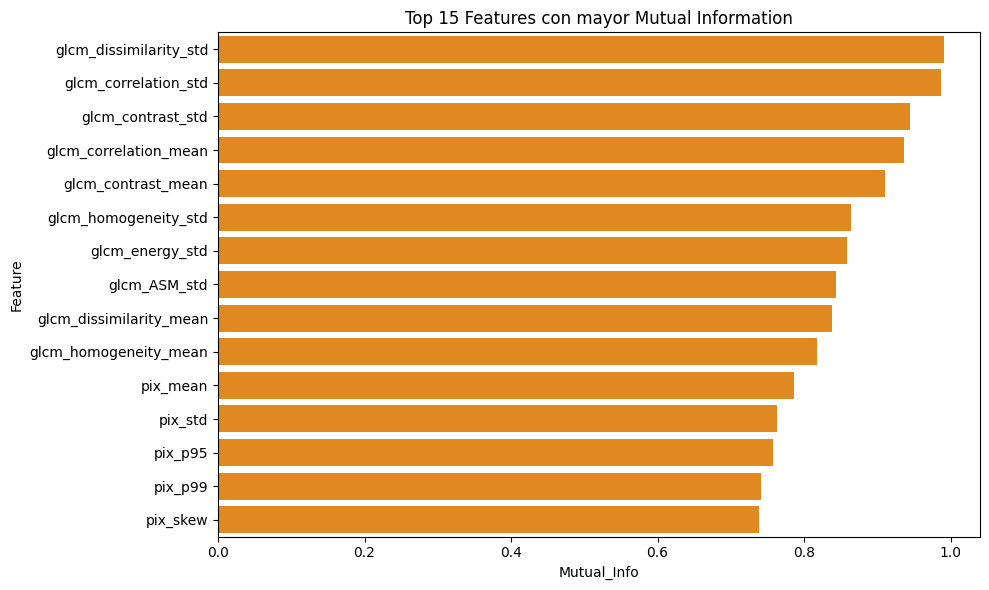

In [79]:
# Visualización
plt.figure(figsize=(10,6))
sns.barplot(data=feature_eval.head(15), x='F_score', y='Feature', color='steelblue')
plt.title("Top 15 Features con mayor F-Score (ANOVA)")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,6))
sns.barplot(data=feature_eval.sort_values('Mutual_Info', ascending=False).head(15),
            x='Mutual_Info', y='Feature', color='darkorange')
plt.title("Top 15 Features con mayor Mutual Information")
plt.tight_layout()
plt.show()

### Analisis de resultados - ANOVA F-score

El F-score evalúa cuánto varía cada característica entre las clases (cuanto mayor el valor, más separa a las clases en promedio).

Las características con mayor F-score fueron:
- glcm_correlation_mean
- pix_p99, pix_p95, pix_p75
- pix_std, pix_p50, pix_mean
- glcm_homogeneity_mean, glcm_energy_mean
<br>

Esto nos indica lo siguiente:
- Los features de intensidad (pix_...) indican que las distribuciones de brillo y contraste (especialmente los percentiles altos y la desviación estándar) varían entre clases, lo cual sugiere diferencias globales de densidad radiográfica o exposición asociadas a las patologías.
- Los features de textura (GLCM), en especial la correlación y homogeneidad, muestran valores muy altos de F-score, lo que podria implicar texturas distintivas entre clases (por ejemplo, patrones vasculares o densidad pulmonar diferentes).
- glcm_correlation_mean domina con diferencia, lo que apunta a que la coherencia estructural de la textura es el descriptor más separable entre tipos de cardiopatía.
<br>

Conclusion:
Las clases presentan diferencias marcadas tanto en la intensidad global de píxeles como en la organización textural interna, confirmando que los features elegidos tienen valor discriminante.

### Analisis de resultados - Mutual Information (MI)

La Mutual Information mide cuánta información (lineal o no lineal) comparte una característica con la etiqueta de clase.

Los valores de MI más altos corresponden a:
- glcm_dissimilarity_std, glcm_correlation_std, glcm_contrast_std
- glcm_homogeneity_std, glcm_energy_std, glcm_ASM_std
- pix_mean, pix_std, pix_p95, pix_p99

Esto nos indica lo siguiente:
- Las medidas de textura (dissimilarity, contrast, homogeneity) no solo difieren en promedio entre clases, sino que contienen información no lineal útil para clasificación.
- La variabilidad (std) de estas propiedades resulta más informativa que su media — esto sugiere que la heterogeneidad local de la textura es más relevante que la textura promedio.
<BR>

Conclusión:
Las texturas GLCM son las más informativas, lo que refuerza su valor como descriptores discriminativos robustos frente a las diferencias estructurales cardíacas y pulmonares.

### Importancia de características en modelos de prueba (Random Forest)

In [80]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Dividir datos
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=42)

# Entrenar modelo
rf = RandomForestClassifier(n_estimators=300, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)

# Evaluación rápida
y_pred = rf.predict(X_test)
print("Reporte de Clasificación (evaluación rápida):")
print(classification_report(y_test, y_pred))

# Importancia de features
importances = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)

Reporte de Clasificación (evaluación rápida):
              precision    recall  f1-score   support

         ASD       0.78      0.43      0.55        49
   ASD_crops       0.33      0.27      0.30        48
      Normal       0.65      0.92      0.76        52
Normal_crops       0.42      0.33      0.37        52
         PDA       0.78      0.85      0.81        54
   PDA_crops       0.48      0.41      0.44        54
         VSD       0.88      0.79      0.83        53
   VSD_crops       0.48      0.75      0.59        52

    accuracy                           0.60       414
   macro avg       0.60      0.59      0.58       414
weighted avg       0.60      0.60      0.59       414



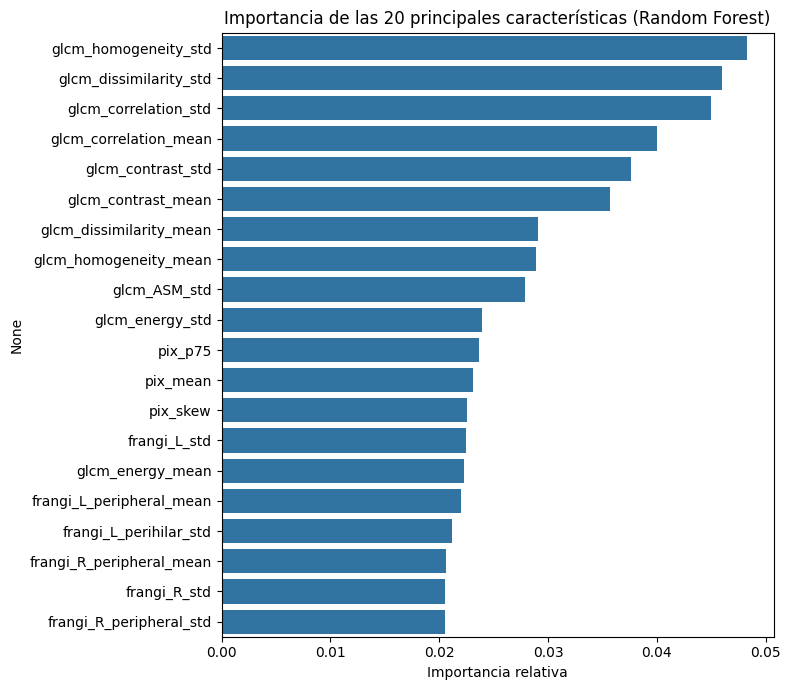

In [81]:
# Gráfica de las 20 más importantes
plt.figure(figsize=(8,7))
sns.barplot(x=importances.values[:20], y=importances.index[:20])
plt.title("Importancia de las 20 principales características (Random Forest)")
plt.xlabel("Importancia relativa")
plt.tight_layout()
plt.show()

Evalamos qué características contribuyen más a la clasificación en un modelo de árboles.

- glcm_homogeneity_std y glcm_dissimilarity_std, mayor importancia relativa.
- Luego glcm_correlation_std, glcm_contrast_std, glcm_homogeneity_mean.
- Aparecen también features de intensidad (pix_mean, pix_skew, pix_p75) y algunos de vesselness (frangi_L_std, frangi_R_std).

Podemos destacar los siguientes puntos:

- El modelo da mayor peso a la variabilidad de textura (std) que a los promedios — nuevamente mostrando que las fluctuaciones locales dentro del pulmón aportan información útil.
- Los features Frangi (vesselness) aparecen en posiciones medias, lo que significa que la complejidad vascular detectada complementa la textura pero no es el factor dominante.
- El desempeño del modelo (accuracy ≈ 0.60, f1 ≈ 0.59) confirma que los features capturan información, aunque la separabilidad no es perfecta (esperable dada la similitud visual entre cardiopatías).


**Conclusion final de importancia de caracteristicas**

Las características GLCM dominan la clasificación inicial, seguidas de las de intensidad. Las de vesselness aportan complementariedad anatómica.

### Visualización en 2D (Embeddings de separabilidad) - PCA y T-SNE

Un embedding es una representación de alta dimensionalidad comprimida en un espacio de menor dimensión, donde se preserva (lo más posible) la estructura o relaciones semánticas de los datos originales.

Es por esto que utilzaremos las tecnicas PCA y T-SNE para el desarrollo de este punto

**PCA** <BR>
Proyección lineal de componentes principales que retienen alrededor del 82 % de la varianza total (0.75 + 0.07).

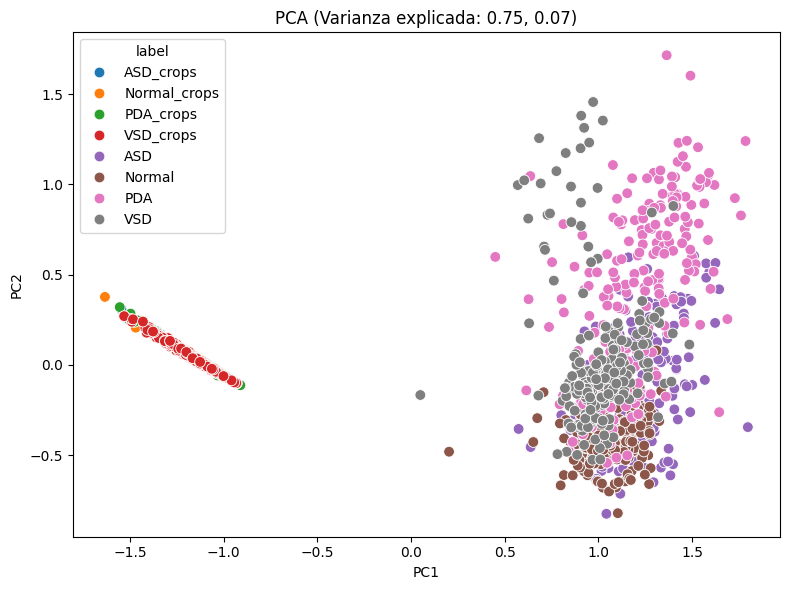

In [82]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
Z = pca.fit_transform(X)

pca_df = pd.DataFrame({'PC1': Z[:,0], 'PC2': Z[:,1], 'label': y})
plt.figure(figsize=(8,6))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='label', s=60)
plt.title(f"PCA (Varianza explicada: {pca.explained_variance_ratio_[0]:.2f}, {pca.explained_variance_ratio_[1]:.2f})")
plt.tight_layout()
plt.show()

- Se observan dos grupos principales:
- Un conjunto compacto (derecha del gráfico) con clases Normal, PDA, VSD.
- Otro grupo más lineal y separado (izquierda) con las versiones CROP.
- La separación entre clases no es perfecta, pero hay estructuras claras, lo que indica que las principales componentes capturan parte de la diferencia entre tipos de imagen.

**TS-SNE**<BR>

Proyección no lineal que preserva vecindad local.

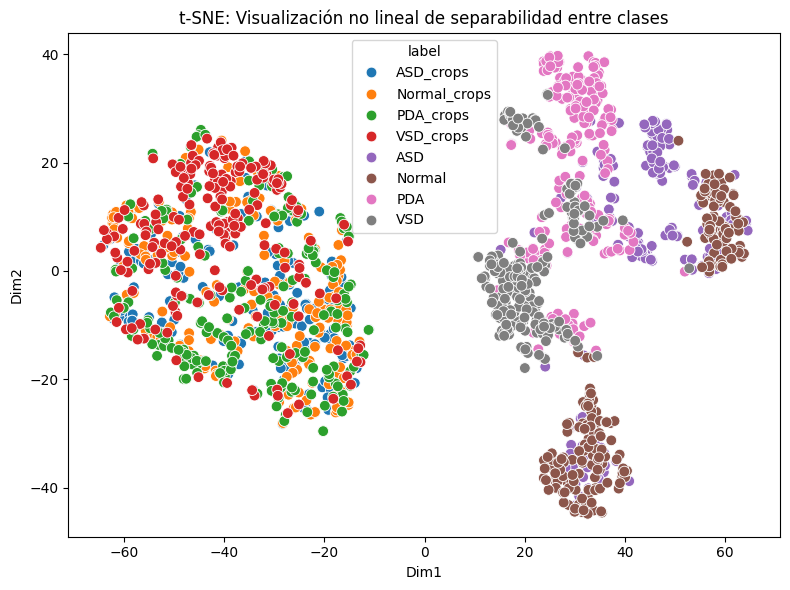

In [83]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42, perplexity=30, learning_rate=200)
Z_tsne = tsne.fit_transform(X)

tsne_df = pd.DataFrame({'Dim1': Z_tsne[:,0], 'Dim2': Z_tsne[:,1], 'label': y})
plt.figure(figsize=(8,6))
sns.scatterplot(data=tsne_df, x='Dim1', y='Dim2', hue='label', s=60)
plt.title("t-SNE: Visualización no lineal de separabilidad entre clases")
plt.tight_layout()
plt.show()


- Las clases Normal, PDA, VSD forman grupos diferenciados, mientras que ASD aparece parcialmente solapado.
- Las versiones CROP también se agrupan de manera coherente dentro de regiones propias, mostrando patrones de similitud internos.

- El t-SNE revela una mejor separabilidad que el PCA, lo cual confirma que la relación entre features y clases es no lineal.
- Las separaciones visibles indican que las características texturales y de intensidad combinadas son capaces de capturar patrones específicos de cada tipo de cardiopatía.

**Conclusion:** Existe una estructura latente diferenciable entre clases, validando la calidad y relevancia de las características seleccionadas.

# 5. Preparación de dataset final (Data Preparation for Modeling)
* División en train/val/test.
* Guardado de los features en un formato reproducible (ej. CSV, parquet, HDF5).

In [ ]:
def create_raw_dataset_split(df: pd.DataFrame,
                             root_folder: str,
                             base_output_dir: str = "dataset_raw",
                             train_pct: float = 0.7,
                             val_pct: float = 0.15,
                             test_pct: float = 0.15):
    """
    Divide un DataFrame de imágenes, copia los archivos a una nueva estructura de directorios
    y crea archivos CSV con rutas RELATIVAS y etiquetas para cada conjunto.

    Args:
        df (pd.DataFrame): DataFrame con las columnas 'image_path' y 'label'.
        root_folder (str): La carpeta raíz donde se creará el 'base_output_dir'.
        base_output_dir (str): El nombre de la carpeta que contendrá el dataset dividido.
        train_pct (float): Porcentaje de datos para el conjunto de entrenamiento.
        val_pct (float): Porcentaje de datos para el conjunto de validación.
        test_pct (float): Porcentaje de datos para el conjunto de prueba.
    """
    if not math.isclose(train_pct + val_pct + test_pct, 1.0):
        raise ValueError("La suma de los porcentajes (train, val, test) debe ser 1.0")

    print("Realizando la división estratificada de los datos...")
    train_df, temp_df = train_test_split(
        df,
        test_size=(val_pct + test_pct),
        random_state=42,
        stratify=df['label']
    )
    relative_test_pct = test_pct / (val_pct + test_pct)
    val_df, test_df = train_test_split(
        temp_df,
        test_size=relative_test_pct,
        random_state=42,
        stratify=temp_df['label']
    )

    print(f"División completada:")
    print(f"  - {len(train_df)} imágenes para entrenamiento.")
    print(f"  - {len(val_df)} imágenes para validación.")
    print(f"  - {len(test_df)} imágenes para prueba.")

    print("Creando estructura de carpetas y copiando archivos...")
    # <-- CAMBIO: Combinar la carpeta raíz y el directorio de salida base.
    base_output_path = Path(root_folder) / base_output_dir

    if base_output_path.exists():
        print(f"ADVERTENCIA: La carpeta '{base_output_path}' ya existe. Se eliminará y se creará de nuevo.")
        shutil.rmtree(base_output_path)

    splits = {"train": train_df, "val": val_df, "test": test_df}

    new_paths_data = []

    for split_name, split_df in splits.items():
        for _, row in tqdm(split_df.iterrows(), total=len(split_df), desc=f"Copiando archivos de '{split_name}'"):
            source_path = Path(row['image_path'])
            label = row['label']

            destination_dir = base_output_path / split_name / label
            destination_dir.mkdir(parents=True, exist_ok=True)

            destination_path = destination_dir / source_path.name
            shutil.copy2(source_path, destination_path)

            # <-- CAMBIO: Calcular y guardar la ruta relativa en lugar de la absoluta.
            relative_path = destination_path.relative_to(base_output_path)

            new_paths_data.append({
                'split': split_name,
                'image_path': str(relative_path).replace("\\", "/"), # Usar formato de ruta universal
                'label': label
            })

    print("Copia de archivos finalizada.")

    print("Creando archivos CSV para cada conjunto...")

    full_new_paths_df = pd.DataFrame(new_paths_data)

    for split_name in splits.keys():
        csv_df = full_new_paths_df[full_new_paths_df['split'] == split_name][['image_path', 'label']]

        csv_path = base_output_path / f"{split_name}.csv"

        csv_df.to_csv(csv_path, index=False)
        print(f"  - Archivo '{csv_path}' creado con {len(csv_df)} registros.")

    print(f"Dataset y archivos CSV creados en: '{base_output_path.resolve()}'")


Leemos nuevamente los datos para tener un df limpio

Vamos a dejar dos dataset preparados.

*   OG: Dataset con las imagenes tal cual se toman de la radiografias, puede incluir torso, cabeza, hombros, brazos, piernas.
*   CROP: Dataset con las imagenes recortadas al area de interes deseada (Torso con visibilidad de corazon, pulmones y costillas)


In [ ]:
data_dir_og = "/content/drive/MyDrive/CARDIOS - PROYECTO INTEGRADOR/Datos_og"
class_names_og = sorted(os.listdir(data_dir_og))

data_dir_crop = "/content/drive/MyDrive/CARDIOS - PROYECTO INTEGRADOR/Datos_crop"
class_names_crop = sorted(os.listdir(data_dir_crop))

print("Clases encontradas OG:", class_names_og)
print("Clases encontradas CROP:", class_names_crop)

image_paths_og = []
labels_og = []

image_paths_crop = []
labels_crop = []

for class_name_og in class_names_og:
    class_dir_og = os.path.join(data_dir_og, class_name_og)
    for img_file_og in os.listdir(class_dir_og):
        image_paths_og.append(os.path.join(class_dir_og, img_file_og))
        labels_og.append(class_name_og)

for class_name_crop in class_names_crop:
    class_dir_crop= os.path.join(data_dir_crop, class_name_crop)
    for img_file_crop in os.listdir(class_dir_crop):
        image_paths_crop.append(os.path.join(class_dir_crop, img_file_crop))
        labels_crop.append(class_name_crop)

df_og = pd.DataFrame({
    'image_path': image_paths_og,
    'label': labels_og
})

df_crop = pd.DataFrame({
    'image_path': image_paths_crop,
    'label': labels_crop
})

Clases encontradas OG: ['ASD', 'Normal', 'PDA', 'VSD']
Clases encontradas CROP: ['ASD_crops', 'Normal_crops', 'PDA_crops', 'VSD_crops']


In [ ]:
create_raw_dataset_split(df_og,
                         root_folder = "/content/drive/MyDrive/CARDIOS - PROYECTO INTEGRADOR/",
                         base_output_dir="dataset_og",
                         train_pct=0.7,
                         val_pct=0.15,
                         test_pct=0.15)

Realizando la división estratificada de los datos...
División completada:
  - 579 imágenes para entrenamiento.
  - 124 imágenes para validación.
  - 125 imágenes para prueba.
Creando estructura de carpetas y copiando archivos...


Copiando archivos de 'test': 100%|██████████| 125/125 [00:28<00:00,  4.41it/s]

Copia de archivos finalizada.
Creando archivos CSV para cada conjunto...
  - Archivo '/content/drive/MyDrive/CARDIOS - PROYECTO INTEGRADOR/dataset_og/train.csv' creado con 579 registros.
  - Archivo '/content/drive/MyDrive/CARDIOS - PROYECTO INTEGRADOR/dataset_og/val.csv' creado con 124 registros.
  - Archivo '/content/drive/MyDrive/CARDIOS - PROYECTO INTEGRADOR/dataset_og/test.csv' creado con 125 registros.
Dataset y archivos CSV creados en: '/content/drive/.shortcut-targets-by-id/1Zcpavy435Lh0_EhKSwRun9CVqJjswIf_/CARDIOS - PROYECTO INTEGRADOR/dataset_og'


In [ ]:
create_raw_dataset_split(df_crop,
                         root_folder = "/content/drive/MyDrive/CARDIOS - PROYECTO INTEGRADOR/",
                         base_output_dir="dataset_crop",
                         train_pct=0.7,
                         val_pct=0.15,
                         test_pct=0.15)

Realizando la división estratificada de los datos...
División completada:
  - 579 imágenes para entrenamiento.
  - 124 imágenes para validación.
  - 125 imágenes para prueba.
Creando estructura de carpetas y copiando archivos...


Copiando archivos de 'test': 100%|██████████| 125/125 [00:34<00:00,  3.61it/s]

Copia de archivos finalizada.
Creando archivos CSV para cada conjunto...
  - Archivo '/content/drive/MyDrive/CARDIOS - PROYECTO INTEGRADOR/dataset_crop/train.csv' creado con 579 registros.
  - Archivo '/content/drive/MyDrive/CARDIOS - PROYECTO INTEGRADOR/dataset_crop/val.csv' creado con 124 registros.
  - Archivo '/content/drive/MyDrive/CARDIOS - PROYECTO INTEGRADOR/dataset_crop/test.csv' creado con 125 registros.
Dataset y archivos CSV creados en: '/content/drive/.shortcut-targets-by-id/1Zcpavy435Lh0_EhKSwRun9CVqJjswIf_/CARDIOS - PROYECTO INTEGRADOR/dataset_crop'


6. Documentación y trazabilidad (Quality & Reproducibility)
* Registro de parámetros aplicados en cada paso.
* Versionado de datos procesados.
* Notas sobre decisiones tomadas y limitaciones observadas.

In [ ]:
import pandas as pd
import os

# CREAMOS UNA CLASE QUE NOS AYUDARA A CARGAR LOS DATOS PARA LOS MODELOS (UTILIZA EL FORMATO DE DATASET GENERADO EN EL PUNTO 5)
# ESTA CLASE ADAPTA LAS RUTAS RELATIVAS A RUTAS ABSOLUTAS DEL ENTORNO DE EJECUCIÓN
class DatasetLoader:
    """
    Carga y prepara los DataFrames de entrenamiento, validación y prueba
    desde archivos CSV contenidos en una carpeta específica.
    """

    def __init__(self, dataset_path: str):
        """
        Inicializa el cargador de datasets con la ruta base de la carpeta.

        Args:
            dataset_path (str): La ruta absoluta o relativa a la carpeta
                                 que contiene los archivos CSV (train.csv,
                                 val.csv, test.csv).
        """
        # Normaliza la ruta y la guarda
        self.dataset_path = os.path.abspath(dataset_path)
        print(f"Ruta base del dataset establecida: {self.dataset_path}")

    def _load_and_process_df(self, filename: str) -> tuple[pd.DataFrame, pd.DataFrame]:
        """
        Método interno para cargar un CSV específico, preprocesar las rutas
        y dividir el DataFrame en X (rutas de imagen) y Y (etiquetas).

        Args:
            filename (str): Nombre del archivo CSV (ej. 'train.csv').

        Returns:
            tuple[pd.DataFrame, pd.DataFrame]: Una tupla con (X, Y) DataFrames.
        """
        file_path = os.path.join(self.dataset_path, filename)

        if not os.path.exists(file_path):
            raise FileNotFoundError(f"El archivo '{filename}' no se encontró en la ruta: {file_path}")

        df = pd.read_csv(file_path)

        # Verificar que las columnas 'image_path' y 'label' existan
        if 'image_path' not in df.columns or 'label' not in df.columns:
            raise ValueError(f"El archivo '{filename}' debe contener las columnas 'image_path' y 'label'.")

        print(f"Archivo {filename} leído. Filas: {len(df)}")

        df['image_path'] = df['image_path'].apply(
            lambda x: os.path.join(self.dataset_path, x)
        )

        # Dividir el DataFrame
        # X: solo la columna 'image_path'
        X = df[['image_path']]
        # Y: solo la columna 'label'
        Y = df[['label']]

        return X, Y


    def get_dataframes(self) -> tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame, pd.DataFrame, pd.DataFrame, pd.DataFrame]:
        """
        Carga y procesa los tres archivos CSV (train, val, test) y regresa
        seis DataFrames (X_train, X_val, X_test, Y_train, Y_val, Y_test).

        Returns:
            tuple: (x_train, x_val, x_test, y_train, y_val, y_test)
        """
        print("\nIniciando carga y preprocesamiento de DataFrames...")

        # Cargar y procesar el conjunto de entrenamiento
        x_train, y_train = self._load_and_process_df('train.csv')

        # Cargar y procesar el conjunto de validación
        x_val, y_val = self._load_and_process_df('val.csv')

        # Cargar y procesar el conjunto de prueba
        x_test, y_test = self._load_and_process_df('test.csv')

        print("\nCarga de DataFrames completada exitosamente.")

        # Regresar los 6 DataFrames
        return x_train, x_val, x_test, y_train, y_val, y_test

In [ ]:
# CARGAMOS LOS DATASET GENERADOS EN EL PUNTO 5 A UNA VARIABLE (SE CARGAN DESDE EL ALMACENAMIENTO PARA NO RECREAR LOS SPLIT EN CADA EJECUCIÓN)
dt_loader = DatasetLoader('/content/drive/MyDrive/CARDIOS - PROYECTO INTEGRADOR/dataset_og')
x_train_og, x_val_og, x_test_og, y_train_og, y_val_og, y_test_og = dt_loader.get_dataframes()

#dt_loader = DatasetLoader('/content/drive/MyDrive/CARDIOS - PROYECTO INTEGRADOR/dataset_crop')
#x_train_crop, x_val_crop, x_test_crop, y_train_crop, y_val_crop, y_test_crop = dt_loader.get_dataframes()

Ruta base del dataset establecida: /content/drive/MyDrive/CARDIOS - PROYECTO INTEGRADOR/dataset_og

Iniciando carga y preprocesamiento de DataFrames...
Archivo train.csv leído. Filas: 579
Archivo val.csv leído. Filas: 124
Archivo test.csv leído. Filas: 125

Carga de DataFrames completada exitosamente.


In [ ]:
#VERIFICAMOS QUE EFECTIVAMENTE NUESTRO DF TIENE RUTAS RELATIVAS AL ROOT DEL RUNTIME
primera_ruta = x_train_og['image_path'].iloc[0]

print("Primera ruta de 'x_train':")
print(primera_ruta)

Primera ruta de 'x_train':
/content/drive/MyDrive/CARDIOS - PROYECTO INTEGRADOR/dataset_og/train/Normal/CONTROL140.jpg


In [ ]:
class ImageVersioner:
    """
    Clase para crear y ejecutar un pipeline de procesamiento de imágenes
    unificada y optimizada con paralelismo.
    """
    def __init__(self, initial_params=None, stepVersioning=True, max_workers=multiprocessing.cpu_count()):
        self.initial_params = initial_params if initial_params is not None else {}
        self.step_versioning = stepVersioning
        self.pipeline_steps = []
        self.max_workers = max_workers
        self.label_encoder = None

    def createPipeline(self, steps: list):
        """Define la secuencia de pasos de transformación."""
        self.pipeline_steps = steps
        print(f"Pipeline creado con {len(steps)} pasos.")

    @staticmethod
    def _save_versioned_image_static(image, base_path, step_name, original_filename, log_enabled):
        """Función estática para guardar imágenes."""
        step_dir = os.path.join(base_path, step_name)
        os.makedirs(step_dir, exist_ok=True)
        save_path = os.path.join(step_dir, original_filename)
        image.save(save_path)
        if log_enabled:
            print(f"  -> Imagen guardada en: {save_path}")

    @staticmethod
    def _process_static(row_data, pipeline_steps, initial_params, base_path, step_versioning, log):
        """
        Función de procesamiento estática. Retorna el objeto PIL.Image final.
        """
        image_path = row_data['image_path']
        original_filename = os.path.basename(image_path)

        # Se asume que image_path ya fue adaptado a la columna 'path' o que se usa 'image_path'
        # Aquí usamos 'image_path' para ser consistentes con la función de carga

        if log:
            print(f"\nProcesando imagen: {original_filename}")

        try:
            # NOTA: Cargar en RGB es seguro, el primer paso del pipeline debe convertir a Grises si es necesario.
            current_image = Image.open(image_path).convert("RGB")

            # Opcional: Guardar la imagen original para referencia
            if step_versioning:
                ImageVersioner._save_versioned_image_static(current_image, base_path, "00_original", original_filename, log)

            # Ejecutar los pasos del pipeline
            for step_name, step_function in pipeline_steps:
                current_image = step_function(current_image, **initial_params)

                # Versionar el resultado si está activado
                if step_versioning:
                    ImageVersioner._save_versioned_image_static(current_image, base_path, step_name, original_filename, log)

            return current_image

        except Exception as e:
            tqdm.write(f"Error procesando {original_filename}: {e}")
            return None

    def pipeline(self, data_df: pd.DataFrame, versioning_root_path: str, label: str, log: bool = False) -> np.ndarray:
        """
        Ejecuta el pipeline sobre las imágenes, paraleliza el procesamiento y
        retorna el tensor X normalizado, listo para el modelo.

        :return: Array de NumPy 4D (N, H, W, 1) con píxeles normalizados [0, 1].
        """

        # --- Preparación del Entorno y Versionado ---
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        version_folder = f"{label}_{timestamp}"
        base_path = os.path.join(versioning_root_path, version_folder)
        os.makedirs(base_path, exist_ok=True)
        print(f"Iniciando pipeline y versionado en: {base_path} con {self.max_workers} procesos paralelos.")

        final_images_pil_list = []

        # --- Procesamiento Paralelo ---
        with ProcessPoolExecutor(max_workers=self.max_workers) as executor:
            futures = [
                executor.submit(self._process_static,
                                row,
                                self.pipeline_steps,
                                self.initial_params,
                                base_path,
                                self.step_versioning,
                                log)
                for index, row in data_df.iterrows()
            ]

            iterator = tqdm(as_completed(futures),
                            total=len(futures),
                            desc=f"Procesando {label}",
                            disable=log)

            for future in iterator:
                result = future.result()
                if result is not None:
                    final_images_pil_list.append(result)

        if not log:
            iterator.close()

        # --- Post-Procesamiento (Conversión a Tensor Final) ---
        print("\nConvirtiendo a tensor y normalizando...")

        if not final_images_pil_list:
            print("Advertencia: No se procesó ninguna imagen.")
            return np.array([])

        # 1. Convertir PIL a NumPy y apilar
        x_np_list = [np.array(img, dtype='uint8') for img in final_images_pil_list]
        x_tensor = np.stack(x_np_list, axis=0)

        # 2. Asegurar el formato (N, H, W, C) - Añadir canal para escala de grises
        if len(x_tensor.shape) == 3:
            # (N, H, W) -> (N, H, W, 1)
            x_tensor = np.expand_dims(x_tensor, axis=-1)

        # 3. Normalización [0, 1] y cambio de tipo de dato a float32
        x_normalized = x_tensor.astype('float32') / 255.0

        print(f"Pipeline finalizado. Tensor X generado con forma: {x_normalized.shape}")
        return x_normalized

    def fit_label_encoder(self, y_train_df: pd.DataFrame):
        """
        Aprende el mapeo de etiquetas de texto a números enteros basado en el
        conjunto de entrenamiento. Esto debe ejecutarse una sola vez.
        """
        if 'label' not in y_train_df.columns:
            raise ValueError("El DataFrame de etiquetas debe contener la columna 'label'.")

        self.label_encoder = LabelEncoder()

        # Ajustar el codificador con las etiquetas de entrenamiento
        self.label_encoder.fit(y_train_df['label'])

        # Guardar el número de clases
        self.num_classes = len(self.label_encoder.classes_)

        print(f"Codificador de etiquetas ajustado con {self.num_classes} clases.")
        print(f"Mapeo de clases: {dict(zip(range(self.num_classes), self.label_encoder.classes_))}")


    def transform_y_encoded(self, y_df: pd.DataFrame) -> np.ndarray:
        """
        Aplica la codificación de etiquetas (texto -> número) seguida de
        One-Hot Encoding (número -> vector binario).
        """
        if self.label_encoder is None:
            raise RuntimeError("Debes llamar a fit_label_encoder(y_train_og) primero para inicializar el codificador.")

        if 'label' not in y_df.columns:
            raise ValueError("El DataFrame de etiquetas debe contener la columna 'label'.")

        #Label Encoding (Texto -> Entero)
        y_label_encoded = self.label_encoder.transform(y_df['label'])


        #One-Hot Encoding (Entero -> Vector Binario)
        y_encoded = to_categorical(y_label_encoded, num_classes=self.num_classes)

        print(f"Etiquetas codificadas generadas con forma: {y_encoded.shape}")
        return y_encoded



In [ ]:
# Funciones Auxiliares

def _pil_to_cv2_gray(image_pil):
    """Convierte PIL (L o RGB) a NumPy/CV2 en escala de grises."""
    img_gray_pil = image_pil.convert('L')
    return np.array(img_gray_pil)

def _cv2_gray_to_pil(img_cv):
    """Convierte NumPy/CV2 (escala de grises) a PIL."""
    return Image.fromarray(img_cv)

#-----FUNCIONES VERSIONABLES-------

def step_convert_to_grayscale(image_pil, **kwargs):
    """0. Convierte la imagen a escala de grises (modo 'L' en PIL)."""
    return image_pil.convert('L')


def step_remove_marker_inpaint(image_pil, **kwargs):
    """1. Quita marcadores circulares mediante detección Hough e inpainting."""

    img_gray = _pil_to_cv2_gray(image_pil)

    # Lógica original de remove_marker_inpaint (simplificada para el pipeline)
    g = cv2.medianBlur(img_gray, 5)
    circles = cv2.HoughCircles(
        g, cv2.HOUGH_GRADIENT, dp=1.2, minDist=kwargs.get('minDist', 60),
        param1=kwargs.get('param1', 120), param2=kwargs.get('param2', 35),
        minRadius=kwargs.get('minRadius', 10), maxRadius=kwargs.get('maxRadius', 60)
    )
    mask = np.zeros_like(img_gray, dtype=np.uint8)

    if circles is not None:
        circles = np.uint16(np.around(circles[0]))
        h, w = img_gray.shape
        # Usamos el parámetro configurable 'head_frac' para el límite vertical si existe
        vertical_limit = int(h * kwargs.get('marker_v_limit', 0.45))

        for x, y, r in circles:
            if y < vertical_limit:
                cv2.circle(mask, (x, y), int(r * kwargs.get('marker_scale', 1.25)), 255, -1)

    if mask.any():
        final_img_cv = cv2.inpaint(img_gray, mask, 3, cv2.INPAINT_TELEA)
    else:
        final_img_cv = img_gray.copy()

    return _cv2_gray_to_pil(final_img_cv)


def step_crop_and_resize(image_pil, **kwargs):
    """
    2. Segmenta tórax, calcula BBox, recorta cabeza/abdomen y aplica fit-to-square.
    Esta función agrupa los sub-pasos: thorax_mask, bbox_from_mask, trim_head_abdomen,
    crop_to_bbox, y fit_to_square.
    """

    # --- 0. Inicialización ---
    img_gray = _pil_to_cv2_gray(image_pil)
    no_marker = img_gray # Asumimos que esta imagen ya fue limpiada en un paso anterior
    h, w = img_gray.shape

    # --- 1. Sub-función: thorax_mask (Segmenta tórax) ---

    def _thorax_mask(img_gray_in):
        """Segmenta tórax (máscara binaria robusta)."""
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
        ce = clahe.apply(img_gray_in)
        inv = cv2.bitwise_not(ce)

        _, th = cv2.threshold(inv, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        th = cv2.morphologyEx(th, cv2.MORPH_OPEN, np.ones((5,5), np.uint8), iterations=1)
        th = cv2.morphologyEx(th, cv2.MORPH_CLOSE, np.ones((15,15), np.uint8), iterations=1)

        num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(th, connectivity=8)
        h_in, w_in = img_gray_in.shape
        cx_allowed = (int(w_in*0.15), int(w_in*0.85))
        candidate_idx = []
        for i in range(1, num_labels):
            area = stats[i, cv2.CC_STAT_AREA]
            cx, cy = centroids[i]
            if area > 0.002 * (h_in*w_in) and cx_allowed[0] <= cx <= cx_allowed[1]:
                candidate_idx.append((area, i))

        mask_out = np.zeros_like(th)
        for _, i in sorted(candidate_idx, reverse=True)[:3]:
            mask_out[labels == i] = 255

        if not mask_out.any():
            if num_labels > 1:
                i = 1 + np.argmax(stats[1:, cv2.CC_STAT_AREA])
                mask_out[labels == i] = 255

        contours, _ = cv2.findContours(mask_out, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        hull_mask = np.zeros_like(mask_out)
        for cnt in contours:
            hull = cv2.convexHull(cnt)
            cv2.drawContours(hull_mask, [hull], -1, 255, -1)

        return cv2.dilate(hull_mask, np.ones((7,7), np.uint8), iterations=1)

    mask = _thorax_mask(no_marker)

    # --- 2. Sub-función: bbox_from_mask (Calcula BBox) ---

    def _bbox_from_mask(mask_in, tighten=kwargs.get('bbox_tighten', 0.02)):
        """BBox apretado a partir de máscara."""
        ys, xs = np.where(mask_in > 0)
        if len(xs) == 0:
            return (0, 0, mask_in.shape[1], mask_in.shape[0])
        x0, x1 = xs.min(), xs.max()
        y0, y1 = ys.min(), ys.max()
        w_in = x1 - x0 + 1
        h_in = y1 - y0 + 1
        x0 += int(w_in * tighten); x1 -= int(w_in * tighten)
        y0 += int(h_in * tighten); y1 -= int(h_in * tighten)
        x0 = max(x0, 0); y0 = max(y0, 0)
        x1 = min(x1, mask_in.shape[1]-1); y1 = min(y1, mask_in.shape[0]-1)
        return (x0, y0, x1, y1)

    x0, y0, x1, y1 = _bbox_from_mask(mask)

    # --- 3. Ajuste Lateral (shrink) ---

    w = x1 - x0 + 1
    shrink_frac = kwargs.get('shrink_frac', 0.10)
    shrink = int(w * shrink_frac)
    x0 = x0 + shrink
    x1 = x1 - shrink
    x1 = max(x1, x0 + 1) # Asegurar ancho mínimo

    # --- 4. Sub-función: trim_head_abdomen (Recorte vertical) ---

    def _trim_head_abdomen(y0_in, y1_in, h_in, head_frac=kwargs.get('head_frac', 0.1), abdomen_frac=kwargs.get('abdomen_frac', 0.20)):
        """Recorta cabeza/abdomen por fracciones verticales."""
        y0_new = max(y0_in, int(h_in * head_frac))
        y1_new = min(y1_in, int(h_in * (1.0 - abdomen_frac)))
        if y1_new <= y0_new:
            return y0_in, y1_in
        return y0_new, y1_new

    y0, y1 = _trim_head_abdomen(y0, y1, h)
    bbox = (x0, y0, x1, y1)

    # --- 5. Sub-función: crop_to_bbox (Recorte final) ---

    def _crop_to_bbox(img_in, bbox_in):
        """Recorta imagen al bbox."""
        x0_in, y0_in, x1_in, y1_in = bbox_in
        return img_in[y0_in:y1_in+1, x0_in:x1_in+1]

    cropped = _crop_to_bbox(no_marker, bbox)

    # --- 6. Sub-función: fit_to_square (Normalización de tamaño) ---

    def _fit_to_square(img_in, size=kwargs.get('size', 320), pad_mode=kwargs.get('pad_mode', "median")):
        """Redimensiona con aspecto y centra en lienzo cuadrado."""
        h_in, w_in = img_in.shape[:2]
        if h_in == 0 or w_in == 0:
             return np.zeros((size, size), dtype=img_in.dtype) # Devuelve negro si está vacío

        scale = min(size / w_in, size / h_in)
        nw, nh = int(round(w_in * scale)), int(round(h_in * scale))

        interp = cv2.INTER_AREA if scale < 1.0 else cv2.INTER_CUBIC
        resized = cv2.resize(img_in, (nw, nh), interpolation=interp)

        canvas = np.zeros((size, size), dtype=img_in.dtype) # Inicializa a negro (constant)

        if pad_mode == "median":
            # Usar la mediana del array redimensionado
            fill = int(np.median(resized))
            canvas.fill(fill)

        # Colocar centrado
        top  = (size - nh) // 2
        left = (size - nw) // 2
        canvas[top:top+nh, left:left+nw] = resized

        # (Lógica de 'replicate' omitida por brevedad, pero puedes incluirla aquí)

        return canvas

    final_img_cv = _fit_to_square(cropped)

    # --- 7. Conversión final y Retorno ---
    return _cv2_gray_to_pil(final_img_cv)


In [ ]:

transformation_steps = [
    ("0_grayscale_convert", step_convert_to_grayscale),
    ("1_remove_marker_inpaint", step_remove_marker_inpaint),
    ("2_crop_and_resize", step_crop_and_resize),
]

initial_params = {
    # Parámetros de step_remove_marker_inpaint
    'minDist': 60,
    'param2': 35,
    'marker_v_limit': 0.45,
    'marker_scale': 1.25,

    # Parámetros de step_crop_and_resize
    'bbox_tighten': 0.02,
    'shrink_frac': 0.10,
    'head_frac': 0.1,
    'abdomen_frac': 0.20,
    'size': 320,
    'pad_mode': 'median',
}


# Inicialización y Asignación del Pipeline

# Inicializamos la clase, habilitando el versionado de cada paso
imv = ImageVersioner(
    initial_params=initial_params,
    stepVersioning=True
)

# Asignamos las funciones al pipeline interno
imv.createPipeline(transformation_steps)

# Ejecución del Pipeline y Generación de Tensores X Normalizados

print("INICIANDO PROCESAMIENTO DE IMÁGENES (GENERACIÓN DE X)")

# X_train: Ejecuta, versiona los resultados y devuelve un array (N, 320, 320, 1) normalizado [0, 1].
X_train_normalized = imv.pipeline(
    data_df=x_train_og,
    versioning_root_path='DataVersioning_Output',
    label='TrainOG',
    log=False
)

# X_test
X_test_normalized = imv.pipeline(
    data_df=x_test_og,
    versioning_root_path='DataVersioning_Output',
    label='TestOG',
    log=False
)

# X_val
X_val_normalized = imv.pipeline(
    data_df=x_val_og,
    versioning_root_path='DataVersioning_Output',
    label='ValOG',
    log=False
)

# --- 4. Codificación de Etiquetas (Generación de Tensores Y Codificados) ---

print("INICIANDO CODIFICACIÓN DE ETIQUETAS (GENERACIÓN DE Y)")
imv.fit_label_encoder(y_train_og)

# Y_train: Convierte el DataFrame de etiquetas a One-Hot Encoding.
Y_train_encoded = imv.transform_y_encoded(y_train_og)

# Y_test
Y_test_encoded = imv.transform_y_encoded(y_test_og)

# Y_val
Y_val_encoded = imv.transform_y_encoded(y_val_og)


# --- 5. Resultados Listos para el Modelo ---

print("RESUMEN DE TENSORES LISTOS")
print(f"X_train (imágenes normalizadas): {X_train_normalized.shape}")
print(f"Y_train (etiquetas codificadas): {Y_train_encoded.shape}")
print(f"X_val   (imágenes normalizadas): {X_val_normalized.shape}")
print(f"Y_val   (etiquetas codificadas): {Y_val_encoded.shape}")
print(f"X_test  (imágenes normalizadas): {X_test_normalized.shape}")
print(f"Y_test  (etiquetas codificadas): {Y_test_encoded.shape}")

#SIGUIENTES PASOS PARA LOS MODELOS
# model.fit(x_train_normalized, y_train_encoded, epochs=..., validation_data=...)




Pipeline creado con 3 pasos.
INICIANDO PROCESAMIENTO DE IMÁGENES (GENERACIÓN DE X)
Iniciando pipeline y versionado en: DataVersioning_Output/TrainOG_20251006_004312 con 2 procesos paralelos.


Procesando TrainOG:   0%|          | 0/579 [00:00<?, ?it/s]


Convirtiendo a tensor y normalizando...
Pipeline finalizado. Tensor X generado con forma: (579, 320, 320, 1)
Iniciando pipeline y versionado en: DataVersioning_Output/TestOG_20251006_004507 con 2 procesos paralelos.


Procesando TestOG:   0%|          | 0/125 [00:00<?, ?it/s]


Convirtiendo a tensor y normalizando...
Pipeline finalizado. Tensor X generado con forma: (125, 320, 320, 1)
Iniciando pipeline y versionado en: DataVersioning_Output/ValOG_20251006_004527 con 2 procesos paralelos.


Procesando ValOG:   0%|          | 0/124 [00:00<?, ?it/s]


Convirtiendo a tensor y normalizando...
Pipeline finalizado. Tensor X generado con forma: (124, 320, 320, 1)
INICIANDO CODIFICACIÓN DE ETIQUETAS (GENERACIÓN DE Y)
Codificador de etiquetas ajustado con 4 clases.
Mapeo de clases: {0: 'ASD', 1: 'Normal', 2: 'PDA', 3: 'VSD'}
Etiquetas codificadas generadas con forma: (579, 4)
Etiquetas codificadas generadas con forma: (125, 4)
Etiquetas codificadas generadas con forma: (124, 4)
RESUMEN DE TENSORES LISTOS
X_train (imágenes normalizadas): (579, 320, 320, 1)
Y_train (etiquetas codificadas): (579, 4)
X_val   (imágenes normalizadas): (124, 320, 320, 1)
Y_val   (etiquetas codificadas): (124, 4)
X_test  (imágenes normalizadas): (125, 320, 320, 1)
Y_test  (etiquetas codificadas): (125, 4)


Imprimimos el arbol del versionado para ver como trabaja

In [ ]:
import os

def imprimir_arbol_archivos(ruta_carpeta, extensiones_a_excluir=None):
    """
    Imprime la estructura de directorios de una carpeta, excluyendo
    las extensiones de archivo especificadas.

    :param ruta_carpeta: La ruta de la carpeta raíz.
    :param extensiones_a_excluir: Una lista o conjunto de extensiones (ej: {'.jpg', '.png'}).
    """
    if extensiones_a_excluir is None:
        extensiones_a_excluir = set()

    exclusiones = {ext.lower() if ext.startswith('.') else '.' + ext.lower()
                   for ext in extensiones_a_excluir}

    print(f"Árbol de archivos para: {ruta_carpeta}\n")

    for raiz, directorios, archivos in os.walk(ruta_carpeta):

        nivel = raiz.replace(ruta_carpeta, '').count(os.sep)
        indentacion = '│   ' * nivel

        if nivel > 0:
            nombre_dir = os.path.basename(raiz)
            print(f"{indentacion}├── {nombre_dir}{os.sep}")

        indentacion_archivos = '│   ' * (nivel + 1)

        archivos_validos = []
        for nombre_archivo in archivos:
            extension = os.path.splitext(nombre_archivo)[1].lower()

            if extension not in exclusiones:
                archivos_validos.append(nombre_archivo)

        if archivos_validos:
            for i, nombre_archivo in enumerate(archivos_validos):
                prefijo = "└── " if i == len(archivos_validos) - 1 else "├── "
                print(f"{indentacion_archivos}{prefijo}{nombre_archivo}")


carpeta_a_revisar = '/content/DataVersioning_Output'
extensiones_a_excluir = {'.jpg', '.jpeg', 'png'}
imprimir_arbol_archivos(carpeta_a_revisar, extensiones_a_excluir)

Árbol de archivos para: /content/DataVersioning_Output

│   ├── TestOG_20251006_004507/
│   │   ├── 1_remove_marker_inpaint/
│   │   ├── 2_crop_and_resize/
│   │   ├── 0_grayscale_convert/
│   │   ├── 00_original/
│   ├── TrainOG_20251006_004312/
│   │   ├── 1_remove_marker_inpaint/
│   │   ├── 2_crop_and_resize/
│   │   ├── 0_grayscale_convert/
│   │   ├── 00_original/
│   ├── ValOG_20251006_004527/
│   │   ├── 1_remove_marker_inpaint/
│   │   ├── 2_crop_and_resize/
│   │   ├── 0_grayscale_convert/
│   │   ├── 00_original/




---

## 1. Visión General del Pipeline ($\mathbf{X}$)

El pipeline descompone la lógica de preprocesamiento de imágenes en **tres pasos modulares** que se ejecutan secuencialmente en **paralelo** (usando `multiprocessing`) sobre los conjuntos de imágenes (Train, Val, Test). La salida final de este proceso es el tensor $\mathbf{X}$ normalizado (`[0, 1]`) con forma $(N, 320, 320, 1)$.

| Paso | Función | Propósito Lógico |
| :--- | :--- | :--- |
| **`0_grayscale_convert`** | `step_convert_to_grayscale` | Convierte la imagen a **escala de grises** (`L` en PIL). Prepara el formato de 1 canal requerido por los pasos de OpenCV. |
| **`1_remove_marker_inpaint`** | `step_remove_marker_inpaint` | **Limpia artefactos:** Usa la detección de círculos de **Hough** e **Inpainting** (relleno inteligente) para eliminar marcadores u objetos ruidosos. |
| **`2_crop_and_resize`** | `step_crop_and_resize` | **Segmentación y Normalización:** Agrupa la segmentación del tórax, el ajuste del *Bounding Box* (BBox), el recorte vertical y la normalización final a **320x320**. |

---

## 2. Preparación de Etiquetas ($\mathbf{Y}$) y Coherencia

La gestión de las etiquetas categóricas es vital para el entrenamiento:

| Tarea | Propósito | Método Clave |
| :--- | :--- | :--- |
| **Label Encoding** | Convierte las etiquetas de texto (ej., 'PDA') a números enteros (ej., 0, 1, 2...). El método `fit_label_encoder` se llama **solo con $\mathbf{Y}_{\text{train}}$** para aprender este mapeo, asegurando que no haya **fuga de información** de los conjuntos de validación/prueba. | `imv.fit_label_encoder(y_train_og)` |
| **One-Hot Encoding** | Convierte los números enteros en vectores binarios (ej., $0 \to [1, 0, 0]$), el formato estándar esperado por la función de pérdida del modelo. | `imv.transform_y_encoded(y_df)` |

### Razón del Formato y Versionamiento

* **Versionamiento (`stepVersioning=True`):** Se guarda la **salida de cada paso** del pipeline de $\mathbf{X}$ en carpetas separadas, asegurando la **trazabilidad** completa de los datos y facilitando la **depuración**.
* **Control Central de Parámetros:** El diccionario `initial_params` centraliza y versiona **todos los hiperparámetros de $\mathbf{X}$**, mientras que el `LabelEncoder` garantiza la **consistencia del mapeo de $\mathbf{Y}$** entre todos los *splits* de datos.

---

## 3. Justificación de Parámetros Clave (`initial_params`)

Los parámetros se ajustaron para optimizar la limpieza de $\mathbf{X}$ y enfocar la red neuronal en la región de interés (el tórax).

| Parámetro | Valor | Justificación Breve |
| :--- | :--- | :--- |
| **`minDist`**, **`param2`** | `60`, `35` | Parámetros de **Hough** para afinar la detección de marcadores circulares. |
| **`marker_v_limit`** | `0.45` | Limita la búsqueda de marcadores a la **parte superior (45%)** de la imagen para evitar el ruido. |
| **`shrink_frac`** | `0.10` | Reduce el BBox lateralmente en un **10%** extra, eliminando estructuras irrelevantes fuera del tórax central. |
| **`head_frac`**, **`abdomen_frac`**| `0.1`, `0.20` | Recorte vertical: Elimina el **10% superior** y el **20% inferior**, enfocando el área en la región torácica central. |
| **`size`** | `320` | Tamaño final de **normalización** (`320x320`), optimizado para el modelo. |
| **`pad_mode`** | `'median'` | Relleno superior a `'constant'`. Las bandas del *fit-to-square* se rellenan con el valor de píxel **mediano** para reducir los bordes bruscos para la CNN. |